# ⤵️Import Libraries

In [159]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px

import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox
from scipy.stats.mstats import zscore

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
#pd.set_option('mode.use_inf_as_null', True)

In [3]:
col_pal = ['#8236CB', 
           '#EB2632']

# 📂Load Data

In [4]:
file_path = 'Healthcare_dataset.xlsx'

In [5]:
drug_df = pd.read_excel(file_path, sheet_name='Dataset')

In [6]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

In [7]:
drug_df.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


Convert feature names into LOWERCASE.

In [8]:
drug_df.columns = list(map(lambda x:x.lower(), list(drug_df.columns)))

# 🧹Cleaning Data

In [9]:
cols = ((drug_df != 'N') & (drug_df != 'Y')).any() 

In [10]:
features = cols[cols].index.tolist()
features

['ptid',
 'persistency_flag',
 'gender',
 'race',
 'ethnicity',
 'region',
 'age_bucket',
 'ntm_speciality',
 'ntm_specialist_flag',
 'ntm_speciality_bucket',
 'dexa_freq_during_rx',
 'risk_segment_prior_ntm',
 'tscore_bucket_prior_ntm',
 'risk_segment_during_rx',
 'tscore_bucket_during_rx',
 'change_t_score',
 'change_risk_segment',
 'adherent_flag',
 'count_of_risks']

In [11]:
cols_ign = ['ptid', 'gender', 'dexa_freq_during_rx', 'count_of_risks']

for cols in features:
    if cols not in cols_ign:
        print(drug_df[cols].value_counts())
        print('\n')

Non-Persistent    2135
Persistent        1289
Name: persistency_flag, dtype: int64


Caucasian           3148
Other/Unknown         97
African American      95
Asian                 84
Name: race, dtype: int64


Not Hispanic    3235
Hispanic          98
Unknown           91
Name: ethnicity, dtype: int64


Midwest          1383
South            1247
West              502
Northeast         232
Other/Unknown      60
Name: region, dtype: int64


>75      1439
65-75    1086
55-65     733
<55       166
Name: age_bucket, dtype: int64


GENERAL PRACTITIONER                                              1535
RHEUMATOLOGY                                                       604
ENDOCRINOLOGY                                                      458
Unknown                                                            310
ONCOLOGY                                                           225
OBSTETRICS AND GYNECOLOGY                                           90
UROLOGY                                

## Checking for null values 

In [12]:
drug_df.isna().any().sum()

0

There are no missing or null values in the dataset.

## Identifying and Handling Outliers 

Identify possible features containing outliers and treat them using different methods.

### Demographics 

> - Gender
> - Race
> - Ethinicity

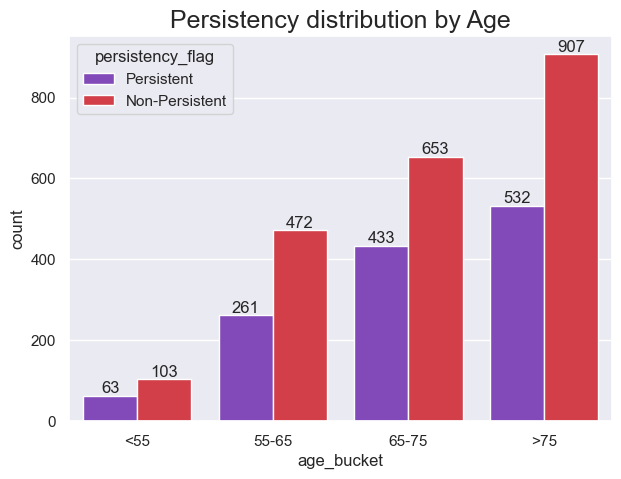

In [13]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='age_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal,
                   order=['<55', '55-65', '65-75', '>75'])
ax.set_title('Persistency distribution by Age', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the patients recorded in the dataset are above *55 years* of age.

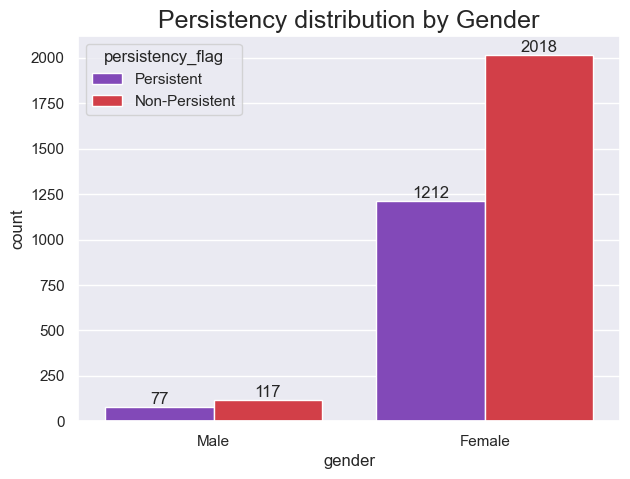

In [14]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='gender', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Gender', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

The **Male** records in the dataset are very low as compared to **Females**. Hence, we can drop this column as it doesn't contribute to model training and would rather add bias in the model.

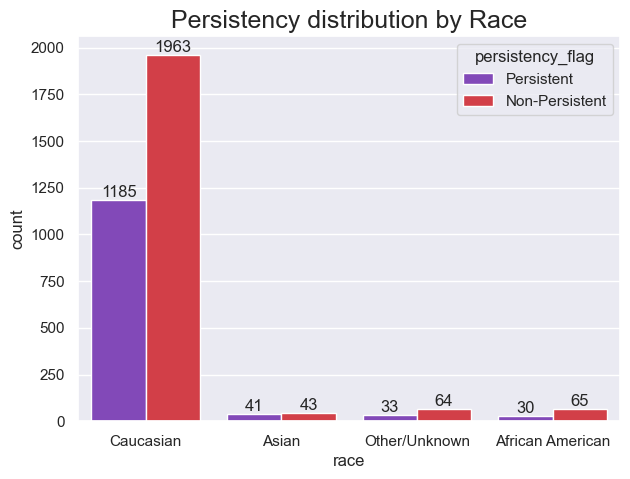

In [15]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='race', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Race', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the population recorded are *Caucasian*. Hence, we can drop the feature **Race** as a non-contributing factor for model training.

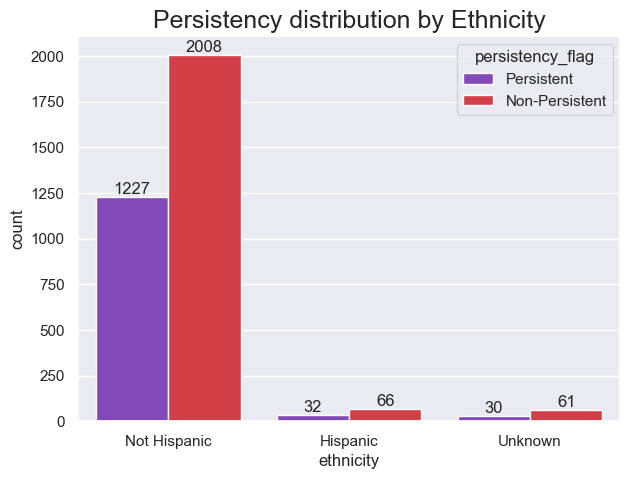

In [16]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ethnicity', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Ethnicity', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the population recorded are **Non Hispanic**. Hence, we can drop the feature **Ethnicity** as a non-contributing factor for model training.

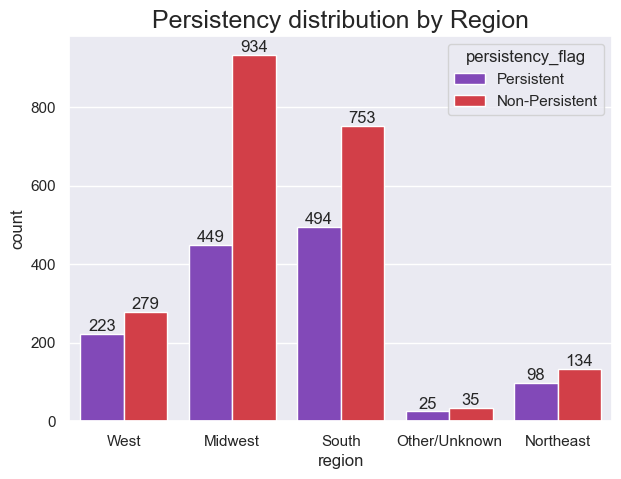

In [17]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='region', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Region', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

### NTM Physician Attributes 

> - NTM Physician specialist
> - Physician Specialist flag
> - Physician Specialist bucket

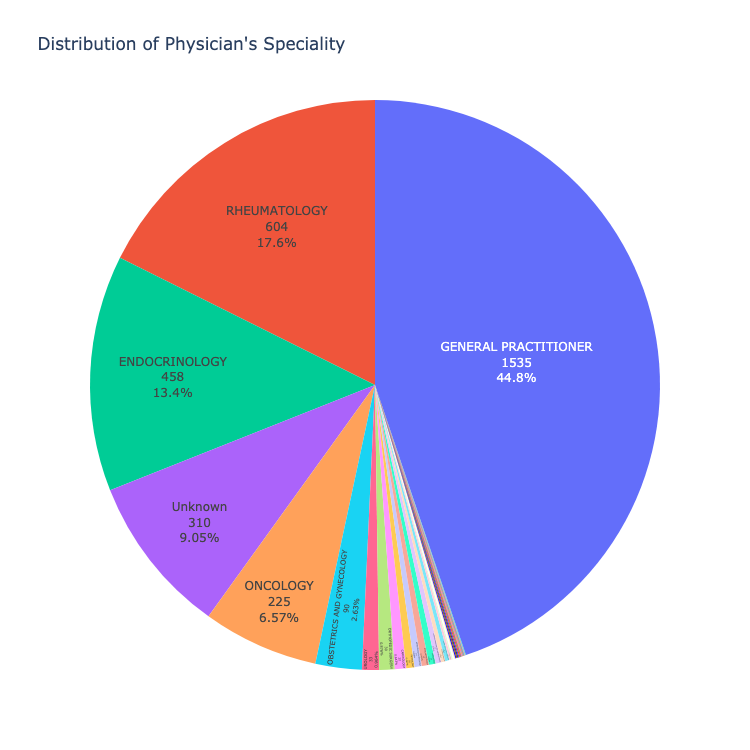

In [97]:
per_phy = drug_df.groupby('ntm_speciality').count()

fig = px.pie(per_phy, 
             values=per_phy.ptid, 
             names=per_phy.index, 
             title='Distribution of Physician\'s Speciality')
fig.update_traces(textposition='inside', 
                  textinfo='value+label+percent')
fig.update_layout(width=750, 
                  height=750)
fig.update(layout_showlegend=False)
fig.show("png")
#fig.show()

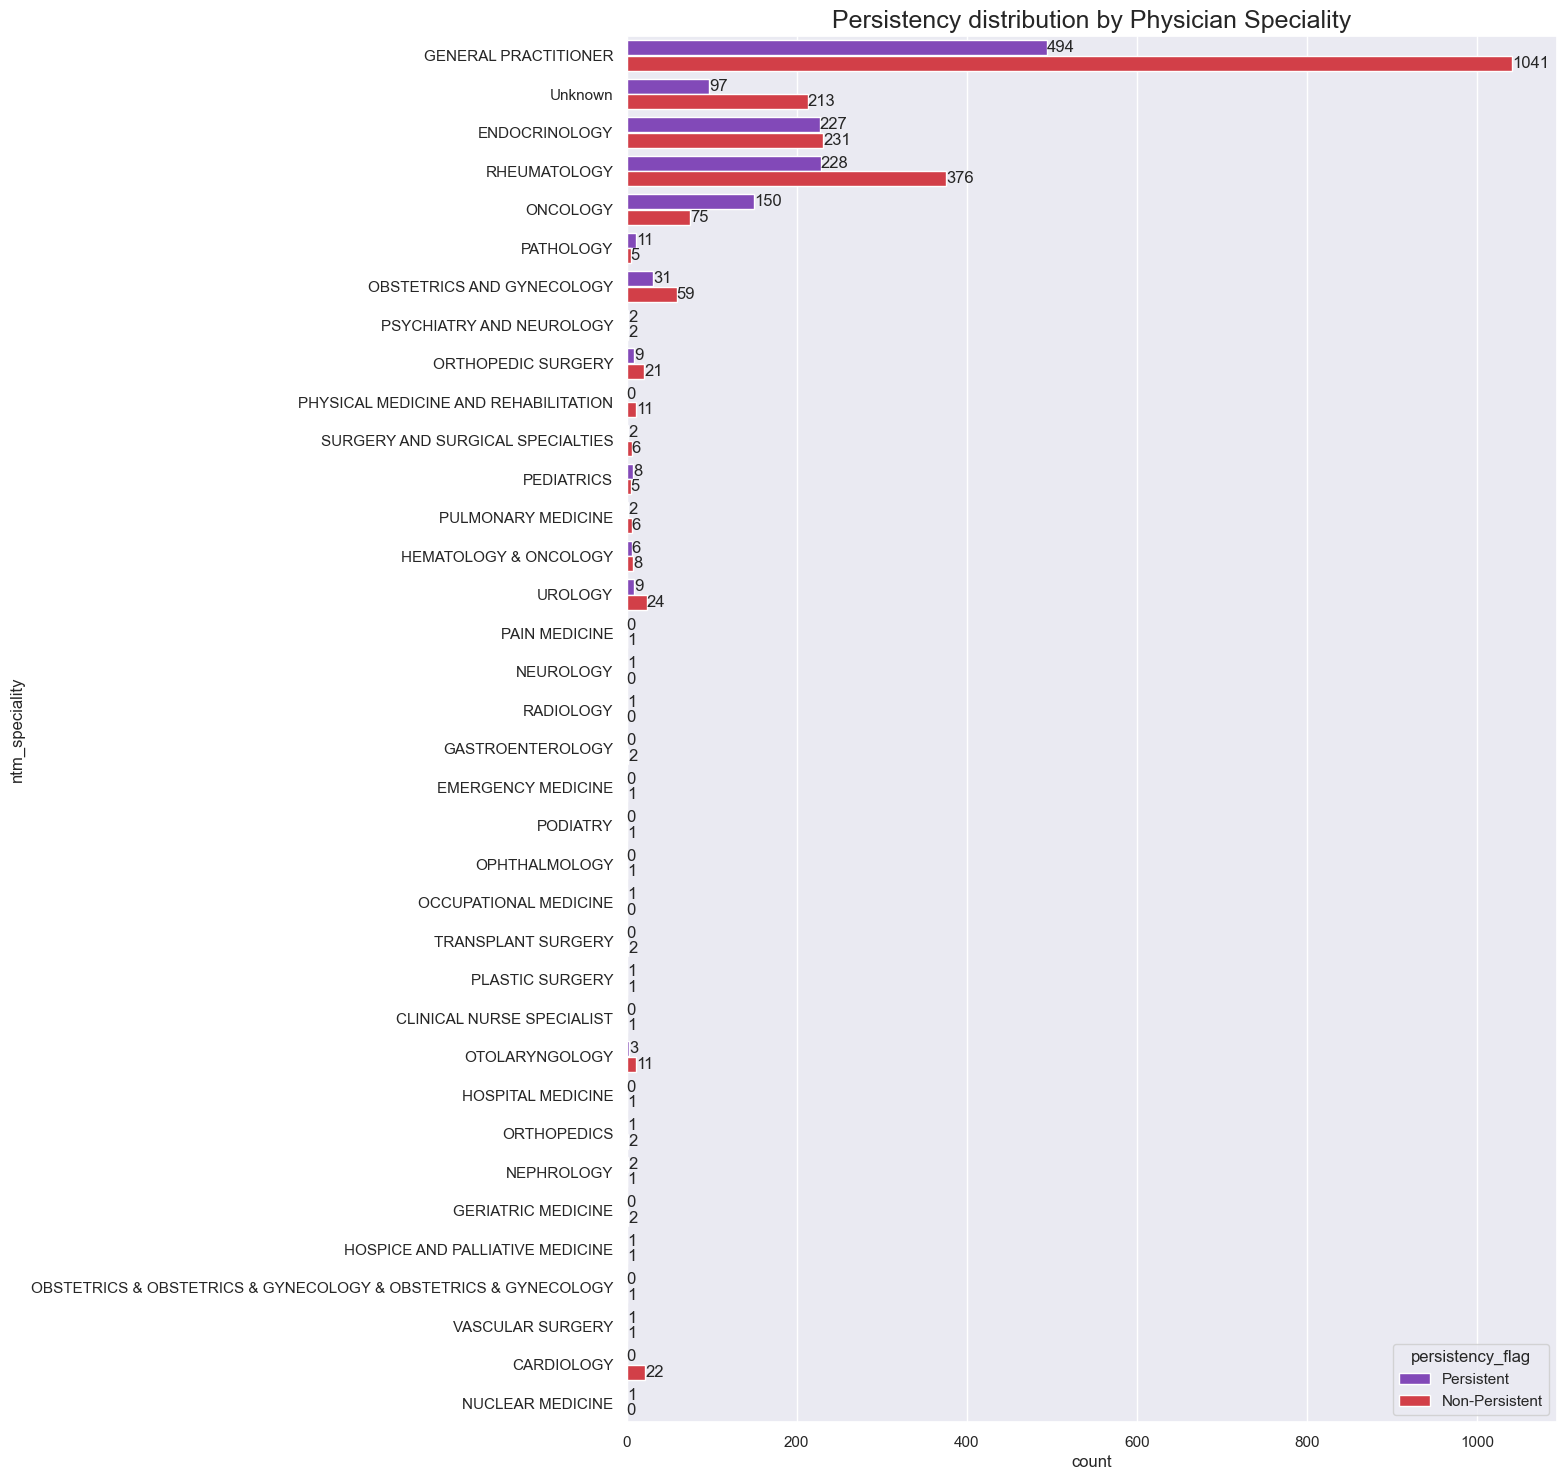

In [18]:
sns.set(rc = {'figure.figsize':(12,18)})
ay = sns.countplot(y='ntm_speciality', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ay.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ay.containers:
    ay.bar_label(label)

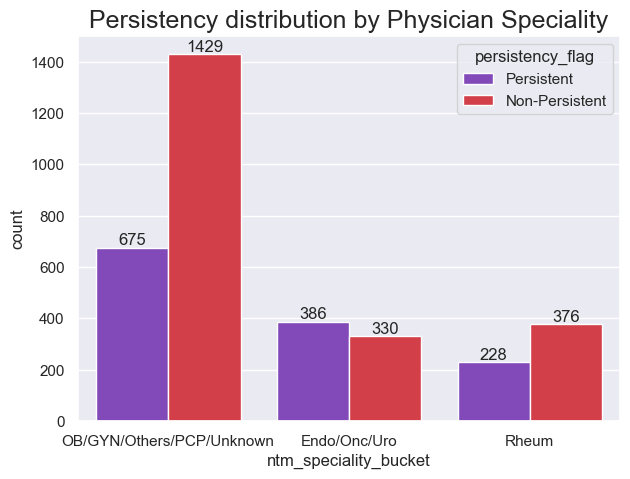

In [19]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_speciality_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

When comparing the features *ntm_speciality* and *ntm_speciality_bucket*, we can observe that the former has significant number of outliers. A workaround is to use the latter feature which divides the specialities into 3 different categories and drop the former attribute.

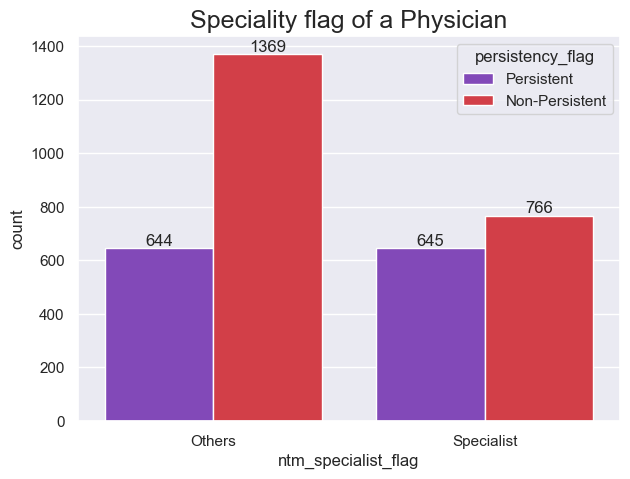

In [20]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_specialist_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Speciality flag of a Physician', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

### Clinical Factors 

> - TScore
> - Risk Segment
> - DEXA
> - Fragility Fracture
> - Glucocorticoid 

### Dexa Scan frequency during NTM Rx 

- *Outliers Identification*

>- ***Boxplot visualisation***

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx')

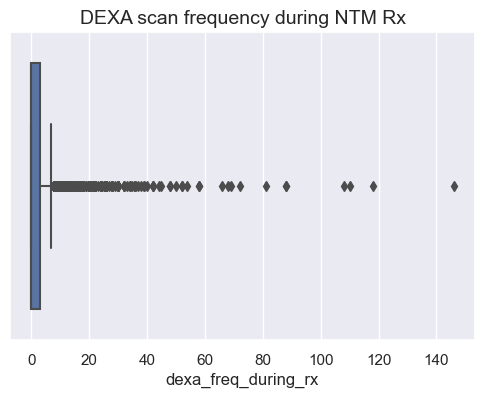

In [21]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='dexa_freq_during_rx', 
                 data=drug_df)
ax.set_title('DEXA scan frequency during NTM Rx', 
             fontsize=14)

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx')

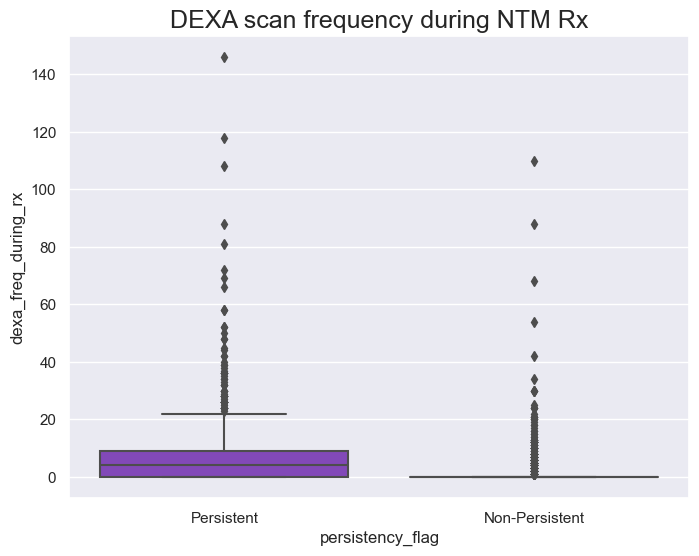

In [22]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.boxplot(y='dexa_freq_during_rx', 
                 x='persistency_flag',
                 data=drug_df,
                 palette=col_pal)
ax.set_title('DEXA scan frequency during NTM Rx', 
             fontsize=18)

>- ***Histogram visualisation***

Text(0.5, 1.0, 'Histogram for DEXA frequency during NTM Rx')

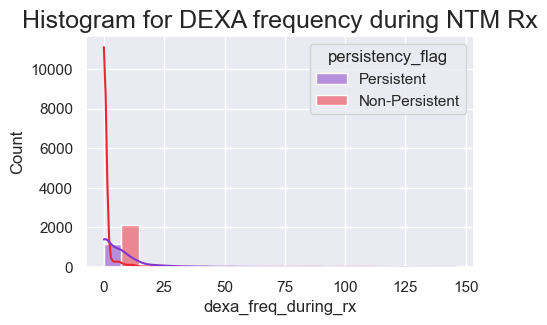

In [23]:
sns.set(rc = {'figure.figsize':(5, 3)})
ax = sns.histplot(x='dexa_freq_during_rx', 
                  hue='persistency_flag',
                  stat='count',
                  data=drug_df,
                  palette=col_pal,
                  multiple='dodge', 
                  bins=10,
                  kde=True)
#ax.set_xlim(0, 40)
#ax.set_ylim(0, 750)
ax.set_title('Histogram for DEXA frequency during NTM Rx', 
             fontsize=18)

- ***Inter Quantile Range(IQR)***

In [24]:
Q1 = drug_df['dexa_freq_during_rx'].quantile(0.25)
Q3 = drug_df['dexa_freq_during_rx'].quantile(0.75)
IQR = Q3 - Q1
lwr_bound = Q1 - (1.5 * IQR)
upr_bound = Q3 + (1.5 * IQR)
drug_df[drug_df['dexa_freq_during_rx'] > upr_bound].groupby('persistency_flag')['dexa_freq_during_rx'].describe()

,count,mean,std,min,25%,50%,75%,max
persistency_flag,,,,,,,,
Non-Persistent,78.0,17.717949,16.795096,8.0,10.0,12.0,19.75,110.0
Persistent,382.0,17.277487,14.905000,8.0,10.0,12.0,19.75,146.0


The *dexa_freq_during_rx* feature has outliers which account to around 460 records. As the strength of total records in the dataset is less in number, removing these outliers is not an option.

>- ***Z-Score method***

In [25]:
thres = 1.96
outliers = []
z_score = np.abs(zscore(drug_df['dexa_freq_during_rx']))

for idx, val in enumerate(z_score):
    if val > thres:
        outliers.append(idx)

In [26]:
len(outliers)

119

>- ***Box-Cox Transformation***

- *Handling outliers*

In [27]:
col = 'dexa_freq_during_rx'
num_col = drug_df[col]

# Find the minimum value in the column
min_value = num_col.min()

# Add a constant to make all values positive
constant = abs(min_value) + 1
transformed_data, lambda_value = boxcox(num_col + constant)

# Create a new column with the transformed data
new_col_name = f"{col}_bc"
drug_df[new_col_name] = transformed_data

Text(0.5, 1.0, 'DEXA scan frequency during therapy(Box-Cox)')

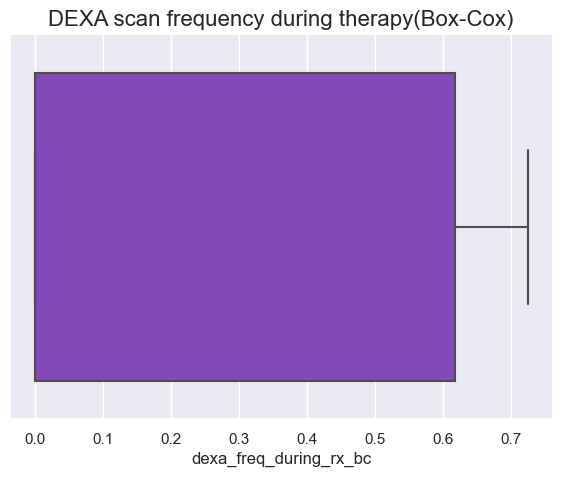

In [28]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.boxplot(x=new_col_name,
                 data=drug_df,
                 palette=col_pal)
ax.set_title('DEXA scan frequency during therapy(Box-Cox)', 
                fontsize=16)

### Multiple Risk Factors Count 

- *Outliers Identification*

>- ***Boxplot visualization***

Text(0.5, 1.0, 'Multiple Risk factors count during NTM Rx')

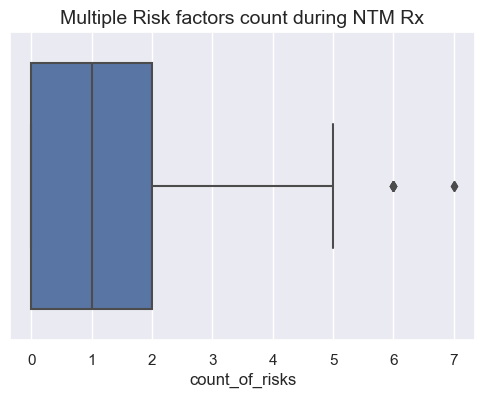

In [29]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='count_of_risks', 
                 data=drug_df)
ax.set_title('Multiple Risk factors count during NTM Rx', 
             fontsize=14)

Text(0.5, 1.0, 'Multiple Risk factors count during NTM Rx by Persistency')

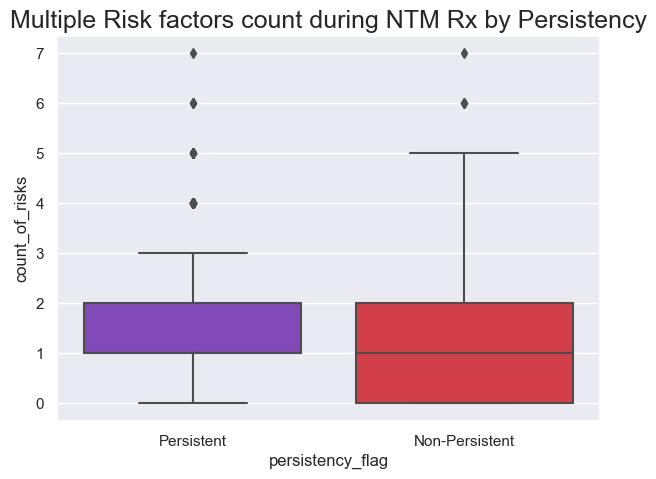

In [30]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.boxplot(y='count_of_risks', 
                 x='persistency_flag',
                 data=drug_df,
                 palette=col_pal)
ax.set_title('Multiple Risk factors count during NTM Rx by Persistency', 
             fontsize=18)

>- ***Histogram visualization***

Text(0.5, 1.0, 'Histogram for Multiple Risk factors during NTM Rx')

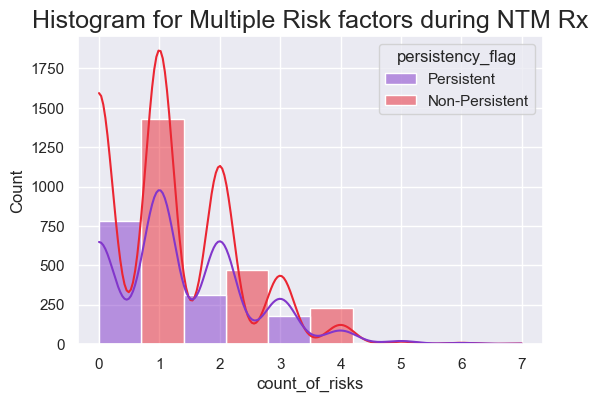

In [31]:
sns.set(rc = {'figure.figsize':(6, 4)})
ax = sns.histplot(x='count_of_risks', 
                  hue='persistency_flag',
                  stat='count',
                  data=drug_df,
                  palette=col_pal,
                  bins=5,
                  multiple='dodge',
                  kde=True)
ax.set_title('Histogram for Multiple Risk factors during NTM Rx', 
             fontsize=18)

In [32]:
drug_df['count_of_risks'].value_counts()

1    1242
0     970
2     781
3     317
4      91
5      15
6       6
7       2
Name: count_of_risks, dtype: int64

- *Handling outliers*

As the *count_of_risks* feature contains 7 different categories and the column describes the no. of risk factors associated with each patient during NTM Rx, the best way to handle the outliers in this section is to reduce the categorisation from 7 to 4 such as 0, 1, 2, and >3.

In [33]:
drug_df['count_of_risks_upd'] = drug_df['count_of_risks']
drug_df.loc[(drug_df['count_of_risks_upd'] >= 3), 'count_of_risks_upd'] = 3

In [34]:
drug_df['count_of_risks_upd'].value_counts()

1    1242
0     970
2     781
3     431
Name: count_of_risks_upd, dtype: int64

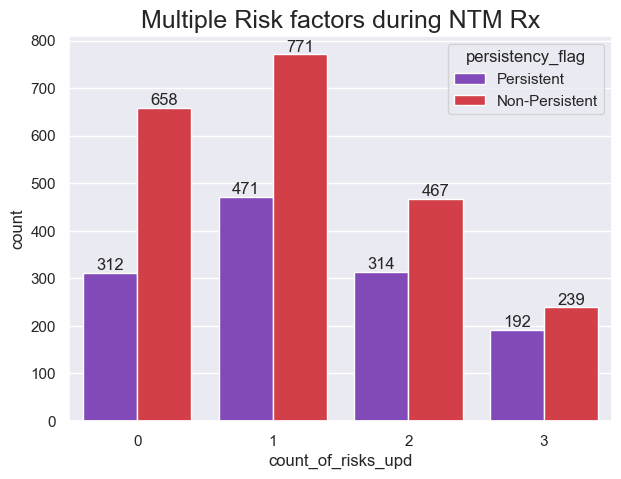

In [35]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='count_of_risks_upd', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Multiple Risk factors during NTM Rx', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

# 🔍Exploratory Data Analysis(EDA)

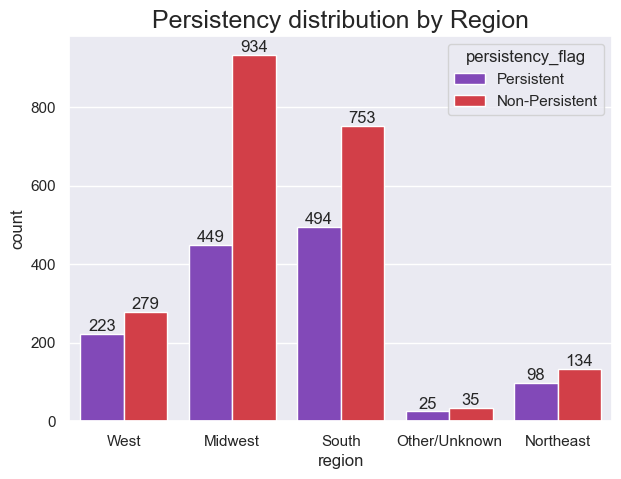

In [36]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='region', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Region', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

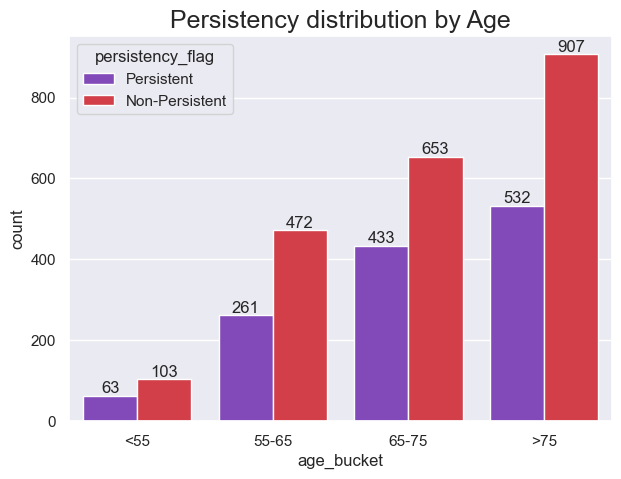

In [37]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='age_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal, 
                   order=['<55', '55-65', '65-75', '>75'])
ax.set_title('Persistency distribution by Age', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [38]:
def create_age_distribution_grid(region_list, 
                                 drug_df, 
                                 col_pal):
    num_regions = len(region_list)
    nrows = num_regions//2
    ncols = num_regions-2
    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=(15, 10))

    for i, region in enumerate(region_list):
        row_idx = i // ncols
        col_idx = i % ncols
        
        ax = axes[row_idx, col_idx]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='age_bucket',
                      data=drug_df[drug_df['region'] == region],
                      hue='persistency_flag',
                      hue_order=['Persistent', 'Non-Persistent'],
                      palette=col_pal,
                      ax=ax, 
                      order=['<55', '55-65', '65-75', '>75'])
        ax.set_title('Age distribution by {}'.format(region), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_regions):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes[row_idx, col_idx]
        ax.set_ylim(0, max_count + 1)
        
    # Removing empty subplots, if any
    for i in range(num_regions, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

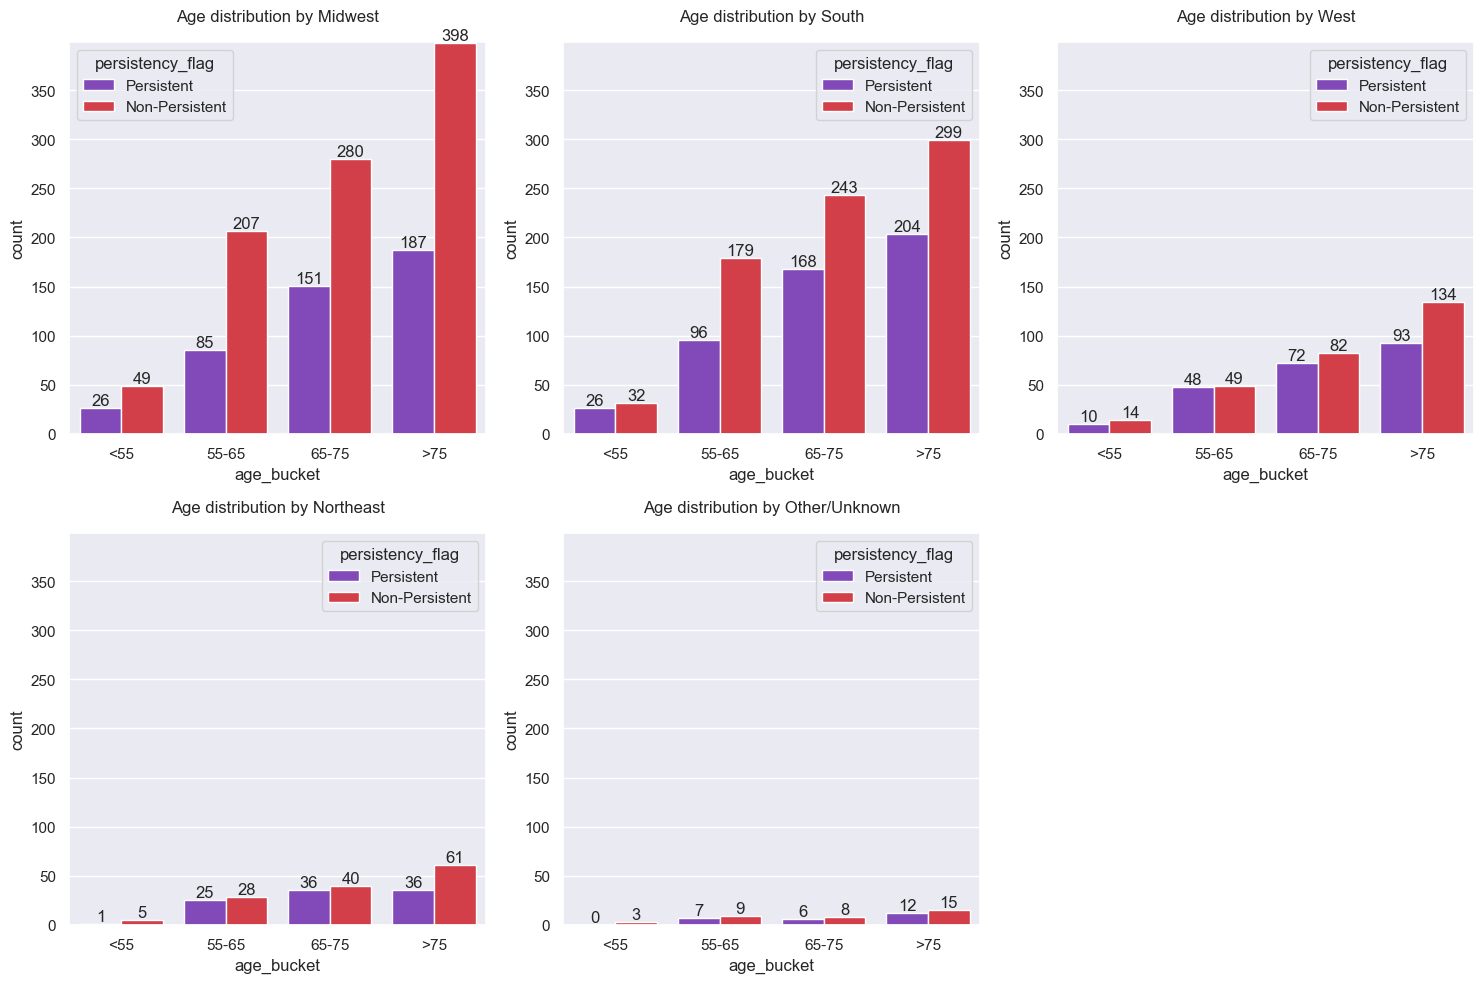

In [39]:
region_list = list(drug_df['region'].value_counts().index)
create_age_distribution_grid(region_list, drug_df, col_pal)

- Based on the distribution by region, we can conclude that majority recordings are from *Midwest* and *South* regions.
- Majority of the patients recorded are above 55 years of age.

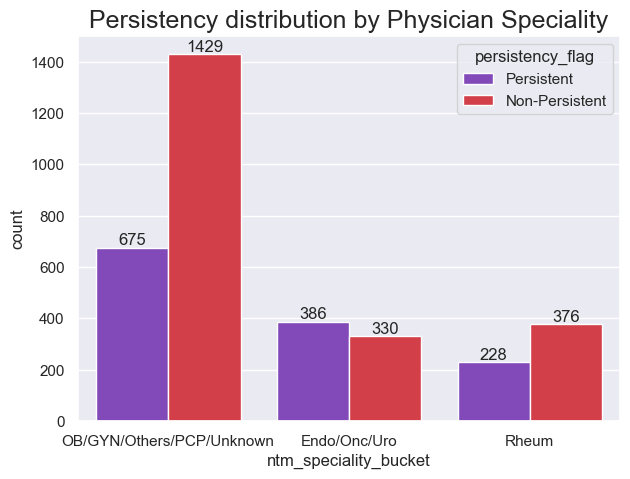

In [40]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_speciality_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

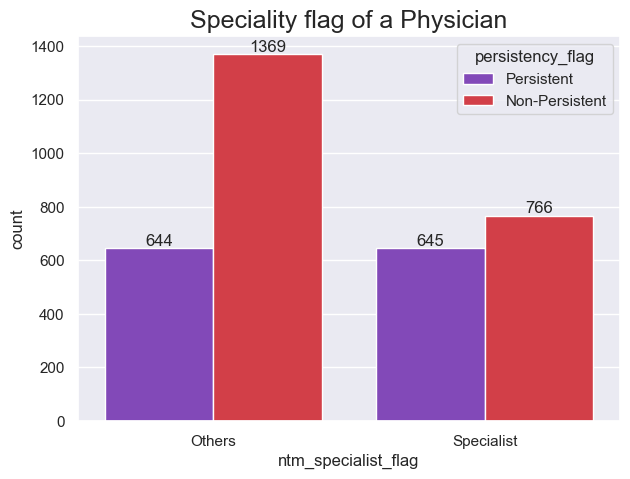

In [41]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_specialist_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Speciality flag of a Physician', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [42]:
def create_physpc_distribution_grid(physician_cat, 
                                    drug_df, 
                                    col_pal):
    num_physicians = len(physician_cat)    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols=num_physicians, 
                             figsize=(15, 5))

    for i, physician in enumerate(physician_cat):
        ax = axes[i]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='ntm_specialist_flag',
                      data=drug_df[drug_df['ntm_speciality_bucket'] == physician],
                      hue='persistency_flag',
                      hue_order=['Persistent', 'Non-Persistent'],
                      palette=col_pal,
                      ax=ax)
        ax.set_title('Specialist distribution by {}'.format(physician), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_physicians):
        ax = axes[i]
        ax.set_ylim(0, max_count + 1)

    plt.tight_layout()
    plt.show()

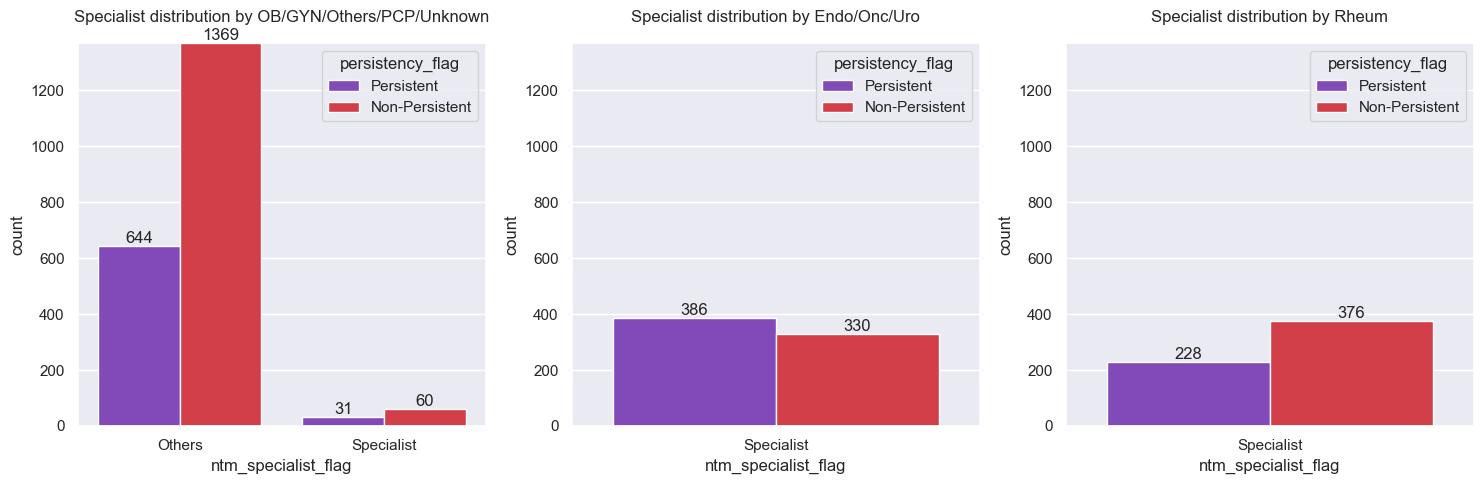

In [43]:
physician_cat = list(drug_df['ntm_speciality_bucket'].value_counts().index)
create_physpc_distribution_grid(physician_cat, drug_df, col_pal)

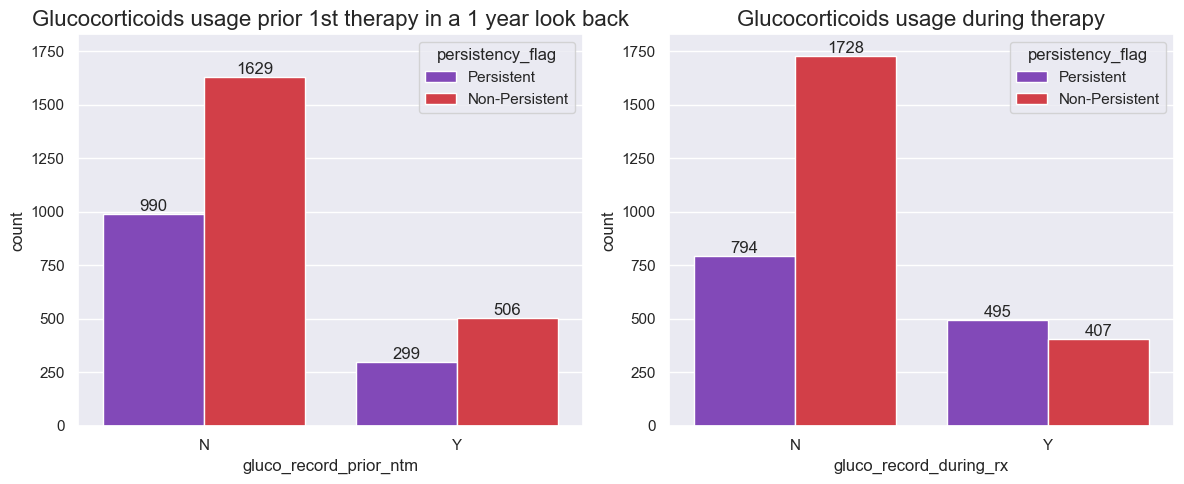

In [44]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'Y')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'Y')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='gluco_record_prior_ntm', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[0].set_title('Glucocorticoids usage prior 1st therapy in a 1 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='gluco_record_during_rx', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[1].set_title('Glucocorticoids usage during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

When we consider the case of usage *Glucocorticoids*, the **Persistent** patients are less compared to **Non-Persistent** patients prior to therapy but vice-versa during therapy. There is increase in the number of patients using *Glucocorticoids* during therapy.

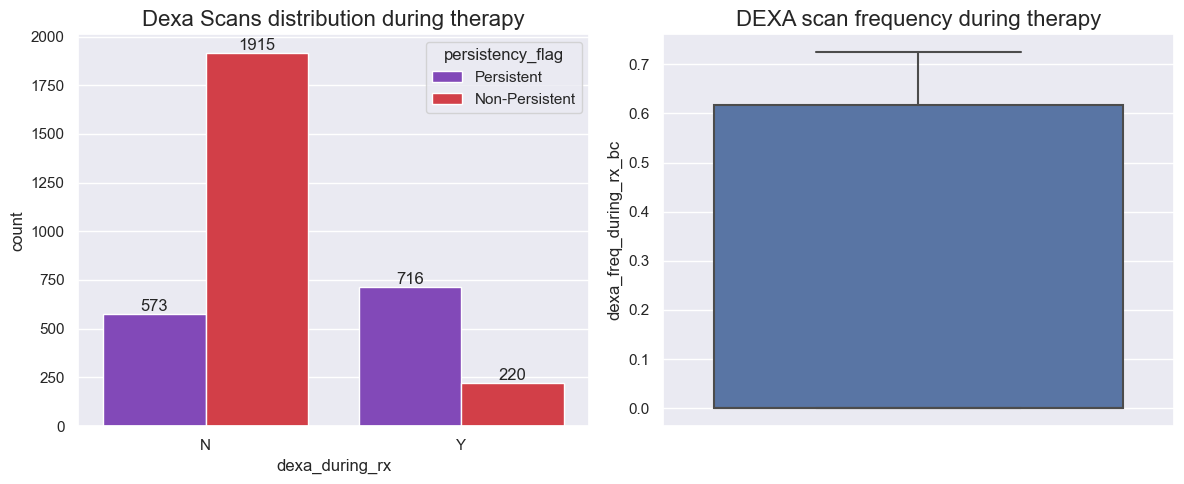

In [45]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='dexa_during_rx', 
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Dexa Scans distribution during therapy', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.boxplot(y='dexa_freq_during_rx_bc', 
                    data=drug_df)
ax[1].set_title('DEXA scan frequency during therapy', 
                fontsize=16)

plt.tight_layout()
plt.show()

*Dexa scan* tests are bone density tests to check the bone strenght.
- Based on the above graph, the *Dexa Scans* is part of the therapy and majority of patients who haven't gone though *Dexa Scans* are **Non-Persistent**.
- *Persistent* patients go though multiple scans during the theraphy.

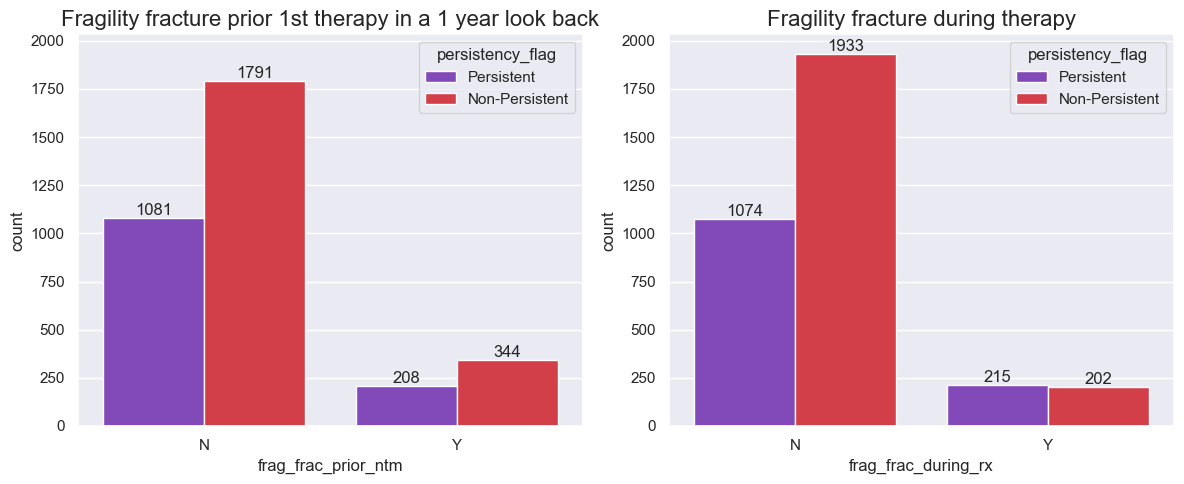

In [46]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_during_rx'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_during_rx'] == 'Y')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_prior_ntm'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_prior_ntm'] == 'Y')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='frag_frac_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Fragility fracture prior 1st therapy in a 1 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='frag_frac_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('Fragility fracture during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

*Fragility Fracture* describes the fractures resulting from fall from standing heights or less. 

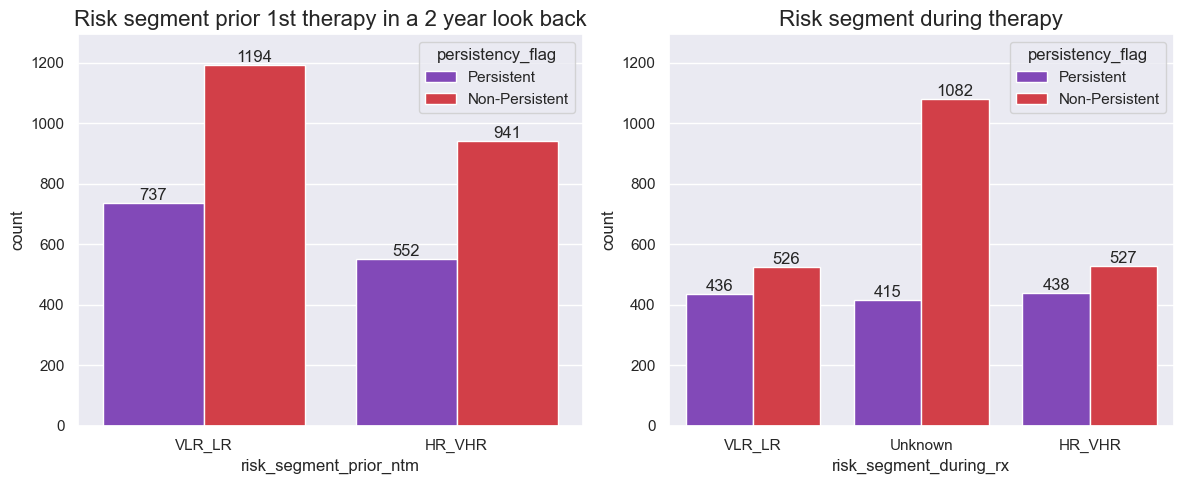

In [47]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_during_rx'] == 'VLR_LR')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_during_rx'] == 'HR_VHR')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_prior_ntm'] == 'VLR_LR')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_prior_ntm'] == 'HR_VHR')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='risk_segment_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Risk segment prior 1st therapy in a 2 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='risk_segment_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('Risk segment during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

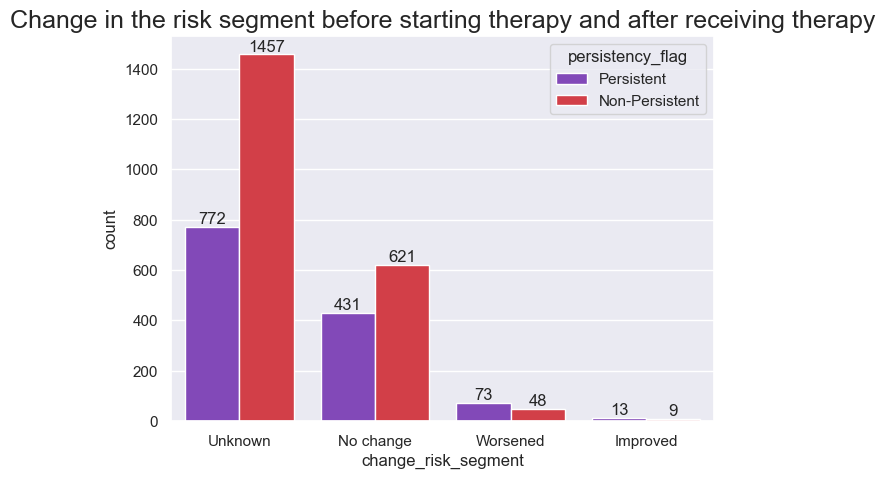

In [48]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='change_risk_segment', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Change in the risk segment before starting therapy and after receiving therapy', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

The *Risk segment during therapy* feature also contains *Unknown* categgory as a value which means there is a possibility of a third category other than **VLR_LR** or **HR_VHR**. 
Assuming that risk segment and change in risk segment for majority of patients is not known during therapy, we can drop these features as they don't provide any useful information.

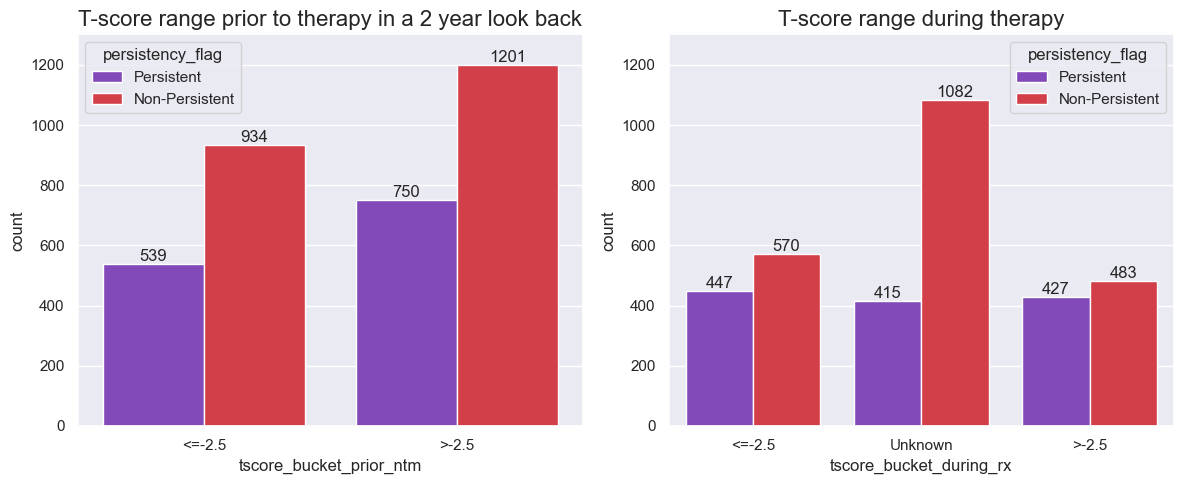

In [49]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_during_rx'] == '<=-2.5')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_during_rx'] == '>-2.5')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_prior_ntm'] == '<=-2.5')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_prior_ntm'] == '>-2.5')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='tscore_bucket_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag',
                      order=['<=-2.5', '>-2.5'],
                      palette=col_pal)
ax[0].set_title('T-score range prior to therapy in a 2 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='tscore_bucket_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('T-score range during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

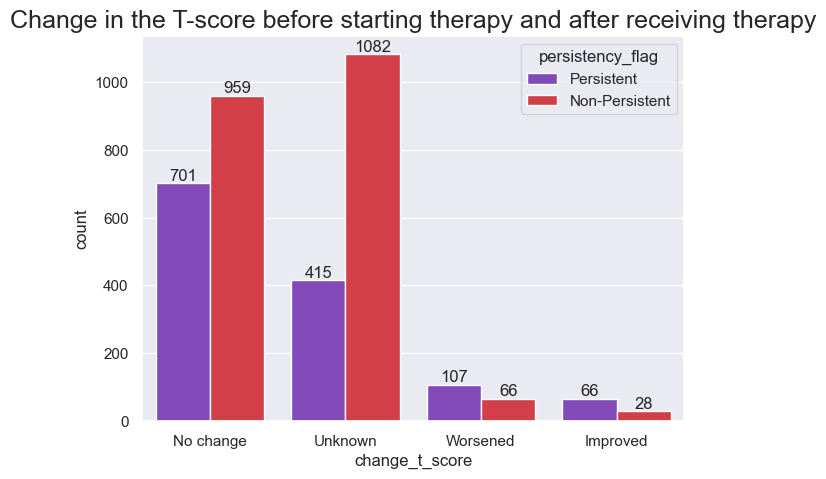

In [50]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='change_t_score', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Change in the T-score before starting therapy and after receiving therapy', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [51]:
columns = list(drug_df.columns)

print('Below is the list of features containing count of \'Unknown\' category value:')
for col in columns:
    if (drug_df[col].dtype != np.int64) & (drug_df[col].dtype != np.float64):
        #print(col)
        unknwn_val = drug_df[col].str.contains('Unknown').sum()
        if unknwn_val != 0:
            print('{}: {}'.format(col, unknwn_val))

Below is the list of features containing count of 'Unknown' category value:
race: 97
ethnicity: 91
region: 60
ntm_speciality: 310
ntm_speciality_bucket: 2104
risk_segment_during_rx: 1497
tscore_bucket_during_rx: 1497
change_t_score: 1497
change_risk_segment: 2229


In [52]:
drug_df['adherent_flag'].value_counts()

Adherent        3251
Non-Adherent     173
Name: adherent_flag, dtype: int64

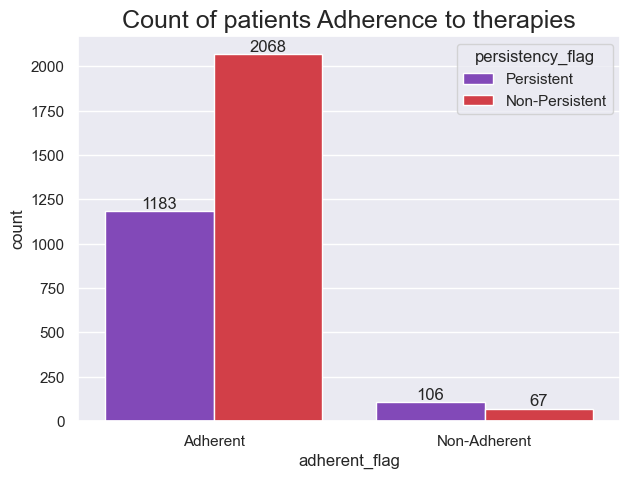

In [53]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='adherent_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Count of patients Adherence to therapies', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

- Above plot contradicts the persistency of the patient to NTM Rx. We can see that majority of the *Non-Persistent* patients were adherent to the therapies.
- The *Non-Persistency* can be due to the some other factors other than *Adherency*.

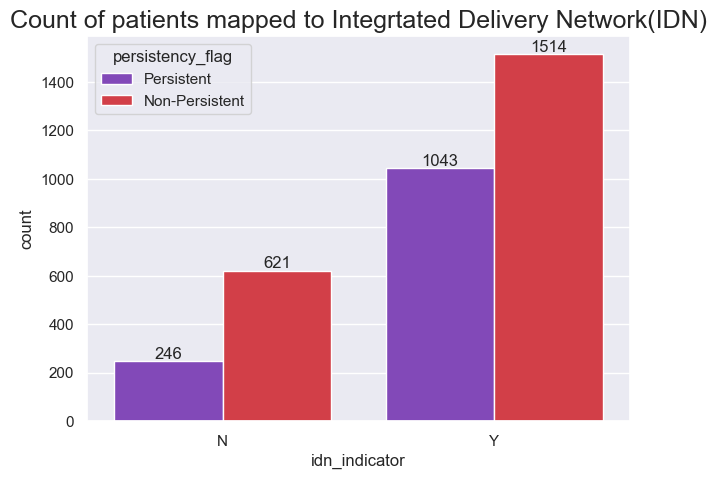

In [54]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='idn_indicator', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Count of patients mapped to Integrtated Delivery Network(IDN)', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

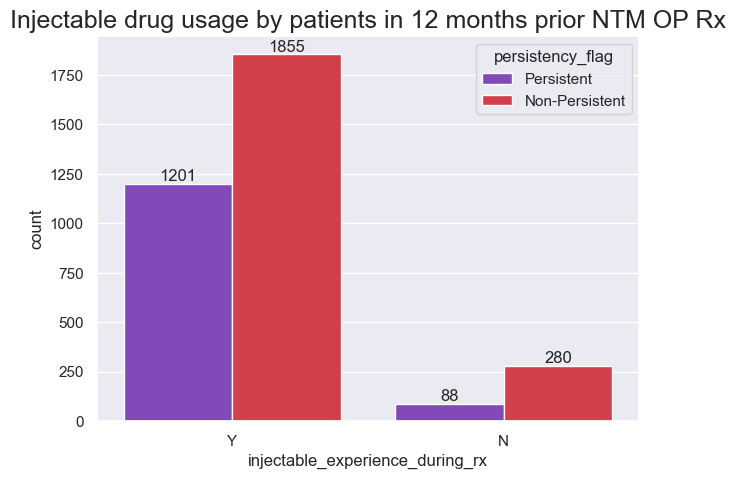

In [55]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='injectable_experience_during_rx', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Injectable drug usage by patients in 12 months prior NTM OP Rx', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

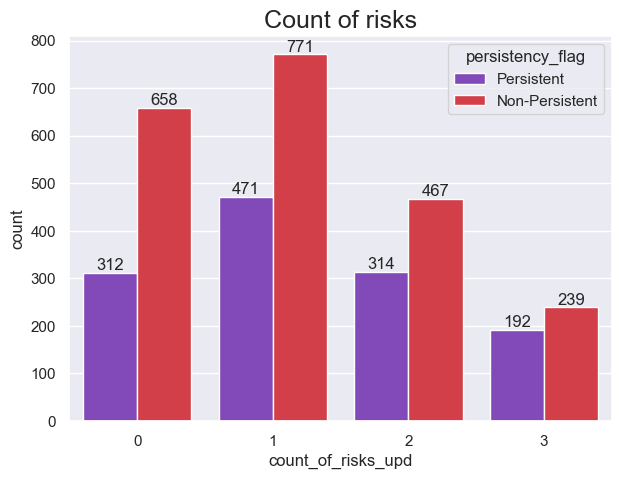

In [56]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='count_of_risks_upd', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Count of risks', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [57]:
risk_factors = []
for col in columns:
    if col.startswith('risk_') & (col != 'risk_segment_prior_ntm') & (col != 'risk_segment_during_rx'):
        risk_factors.append(col)
        
risk_factors

['risk_type_1_insulin_dependent_diabetes',
 'risk_osteogenesis_imperfecta',
 'risk_rheumatoid_arthritis',
 'risk_untreated_chronic_hyperthyroidism',
 'risk_untreated_chronic_hypogonadism',
 'risk_untreated_early_menopause',
 'risk_patient_parent_fractured_their_hip',
 'risk_smoking_tobacco',
 'risk_chronic_malnutrition_or_malabsorption',
 'risk_chronic_liver_disease',
 'risk_family_history_of_osteoporosis',
 'risk_low_calcium_intake',
 'risk_vitamin_d_insufficiency',
 'risk_poor_health_frailty',
 'risk_excessive_thinness',
 'risk_hysterectomy_oophorectomy',
 'risk_estrogen_deficiency',
 'risk_immobilization',
 'risk_recurring_falls']

In [58]:
risk_factor_df = pd.DataFrame(columns=['risk_factor', 'patient_count', \
                                       'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(risk_factors):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    risk_factor_df.loc[idx] = [col.replace('risk_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
risk_factor_df.sort_values(by='patient_count', 
                           ascending=False, 
                           inplace=True, 
                           ignore_index=True)

In [59]:
risk_factor_df

,risk_factor,patient_count,persistent_patient_count,non-persistent_patient_count
0,vitamin_d_insufficiency,1636,607,954
1,smoking_tobacco,644,306,338
2,chronic_malnutrition_or_malabsorption,470,205,265
3,family_history_of_osteoporosis,358,133,225
4,patient_parent_fractured_their_hip,256,100,156
5,poor_health_frailty,192,55,137
6,type_1_insulin_dependent_diabetes,139,46,93
7,rheumatoid_arthritis,130,66,64
8,untreated_chronic_hypogonadism,127,69,58
9,recurring_falls,69,21,48


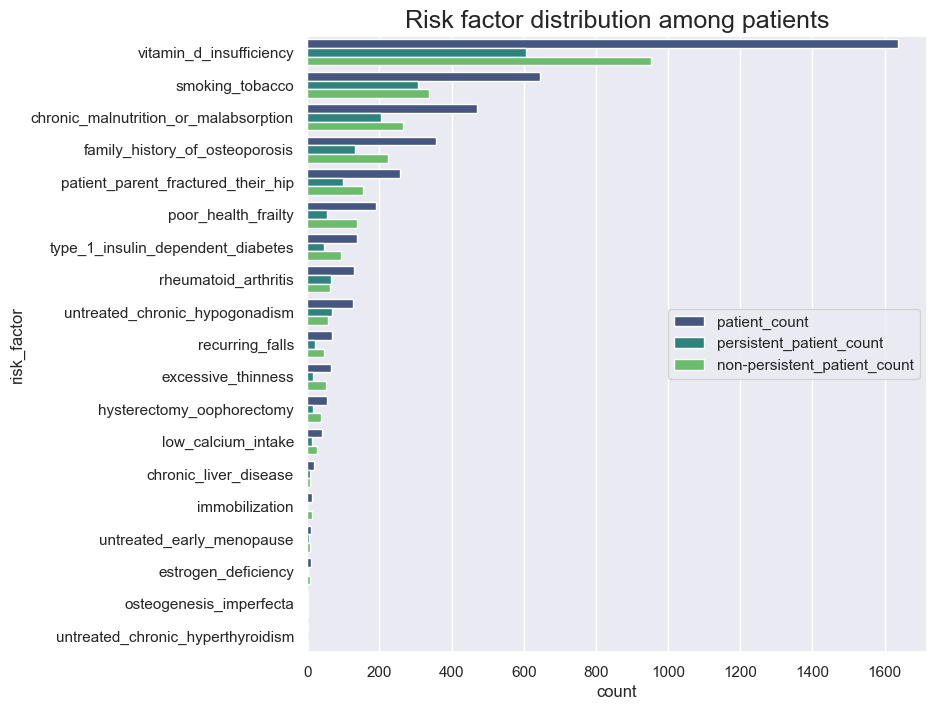

In [60]:
risk_factor_df_meltd = risk_factor_df.melt(id_vars='risk_factor', 
                                           var_name='Count Type', 
                                           value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='risk_factor', 
                 x='count',
                 data=risk_factor_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Risk factor distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')

In [61]:
comorbidity_factors = []
for col in columns:
    if col.startswith('comorb_'):
        comorbidity_factors.append(col)
        
comorbidity_factors

['comorb_encounter_for_screening_for_malignant_neoplasms',
 'comorb_encounter_for_immunization',
 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx',
 'comorb_vitamin_d_deficiency',
 'comorb_other_joint_disorder_not_elsewhere_classified',
 'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx',
 'comorb_long_term_current_drug_therapy',
 'comorb_dorsalgia',
 'comorb_personal_history_of_other_diseases_and_conditions',
 'comorb_other_disorders_of_bone_density_and_structure',
 'comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias',
 'comorb_osteoporosis_without_current_pathological_fracture',
 'comorb_personal_history_of_malignant_neoplasm',
 'comorb_gastro_esophageal_reflux_disease']

In [62]:
comorb_factor_df = pd.DataFrame(columns=['comorbidity_factor', 'patient_count',
                                         'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(comorbidity_factors):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    comorb_factor_df.loc[idx] = [col.replace('comorb_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
comorb_factor_df.sort_values(by='patient_count', 
                             ascending=False, 
                             inplace=True, 
                             ignore_index=True)

In [63]:
comorb_factor_df

,comorbidity_factor,patient_count,persistent_patient_count,non-persistent_patient_count
0,disorders_of_lipoprotein_metabolism_and_other_...,1659,489,965
1,encounter_for_screening_for_malignant_neoplasms,1533,446,690
2,encounter_for_immunization,1513,460,684
3,"encntr_for_general_exam_w_o_complaint,_susp_or...",1352,545,608
4,vitamin_d_deficiency,1093,545,548
5,other_joint_disorder_not_elsewhere_classified,999,552,447
6,osteoporosis_without_current_pathological_frac...,917,448,469
7,long_term_current_drug_therapy,817,557,260
8,encntr_for_oth_sp_exam_w_o_complaint_suspected...,791,447,344
9,dorsalgia,779,443,336


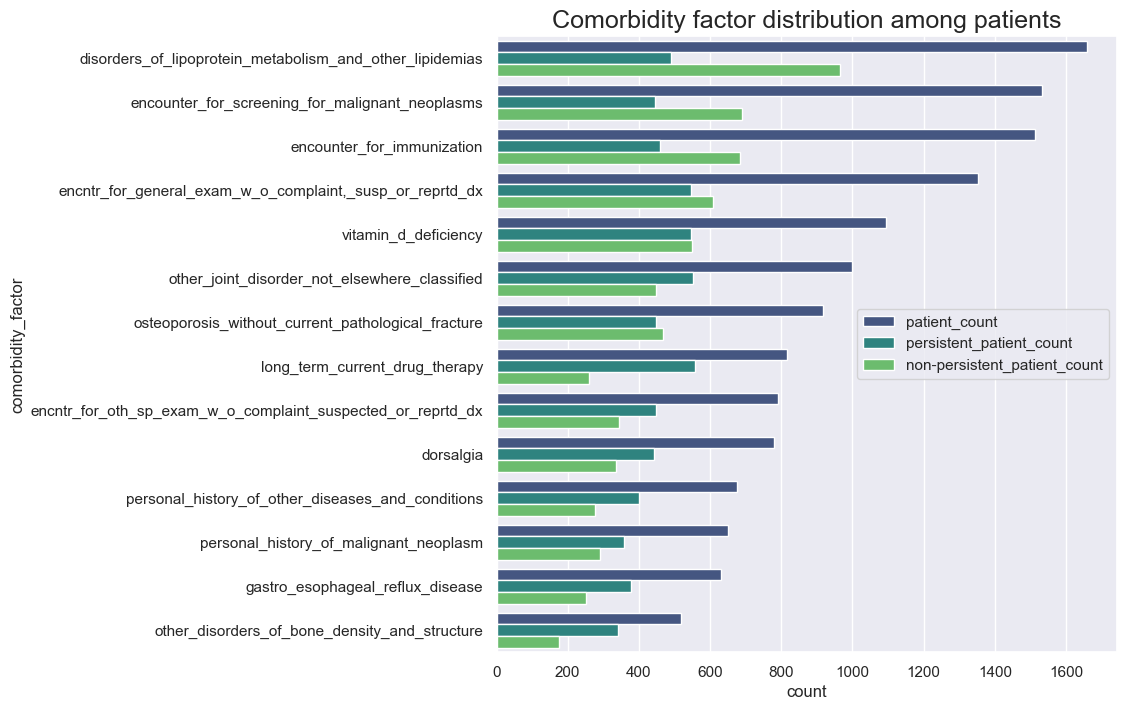

In [64]:
comorb_factor_df_meltd = comorb_factor_df.melt(id_vars='comorbidity_factor', 
                                               var_name='Count Type', 
                                               value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='comorbidity_factor', 
                 x='count',
                 data=comorb_factor_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Comorbidity factor distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')

In [65]:
concomitant_drugs = []
for col in columns:
    if col.startswith('concom_'):
        concomitant_drugs.append(col)
        
concomitant_drugs

['concom_cholesterol_and_triglyceride_regulating_preparations',
 'concom_narcotics',
 'concom_systemic_corticosteroids_plain',
 'concom_anti_depressants_and_mood_stabilisers',
 'concom_fluoroquinolones',
 'concom_cephalosporins',
 'concom_macrolides_and_similar_types',
 'concom_broad_spectrum_penicillins',
 'concom_anaesthetics_general',
 'concom_viral_vaccines']

In [66]:
cocom_drug_df = pd.DataFrame(columns=['concomitant_drug', 'patient_count', \
                                       'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(concomitant_drugs):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    cocom_drug_df.loc[idx] = [col.replace('concom_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
cocom_drug_df.sort_values(by='patient_count', 
                          ascending=False, 
                          inplace=True, 
                          ignore_index=True)

In [67]:
cocom_drug_df

,concomitant_drug,patient_count,persistent_patient_count,non-persistent_patient_count
0,narcotics,1233,617,616
1,cholesterol_and_triglyceride_regulating_prepar...,1182,544,638
2,systemic_corticosteroids_plain,973,548,425
3,anti_depressants_and_mood_stabilisers,959,443,516
4,fluoroquinolones,637,360,277
5,cephalosporins,603,367,236
6,macrolides_and_similar_types,571,352,219
7,anaesthetics_general,497,317,180
8,broad_spectrum_penicillins,439,275,164
9,viral_vaccines,353,245,108


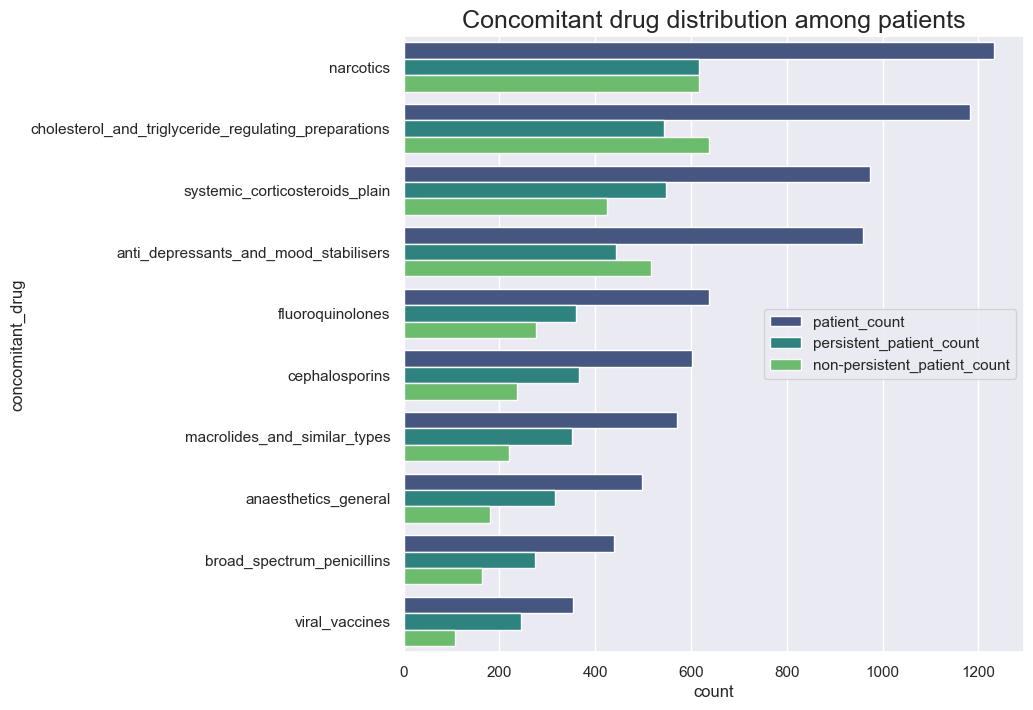

In [69]:
cocom_drug_df_meltd = cocom_drug_df.melt(id_vars='concomitant_drug', 
                                         var_name='Count Type', 
                                         value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='concomitant_drug', 
                 x='count',
                 data=cocom_drug_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Concomitant drug distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')

# 📋Feature Selection

## RFECV 

In [70]:
target = drug_df['persistency_flag']
drug_df.drop(['persistency_flag'], 
             axis=1, 
             inplace=True)

#### Convert categorical to numerical 

In [71]:
dexa_col = drug_df[['dexa_freq_during_rx_bc']]
X = drug_df.drop(['ptid', 'dexa_freq_during_rx', 'dexa_freq_during_rx_bc'], axis=1)

In [87]:
lbl_enc = LabelEncoder()
X = X.apply(lbl_enc.fit_transform)
X.head()

,gender,race,ethnicity,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,...,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks_upd,dexa_freq_during_rx_bc
0,1,2,1,4,3,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1,1,1,4,0,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,3,0,0,1,5,0,1,0,0,...,1,0,0,0,0,0,0,0,2,0.0
3,0,2,1,0,3,5,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0.0
4,0,2,1,0,3,5,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0.0


In [77]:
X = pd.concat([X, dexa_col], axis=1)

In [78]:
target = lbl_enc.fit_transform(target)
target

array([1, 0, 0, ..., 1, 0, 0])

**Estimator: Logistic Regression**

In [88]:
lr = LogisticRegression()
rfecv_lr = RFECV(estimator=lr, 
                step=1, 
                cv=StratifiedKFold(10),
                scoring='accuracy')
rfecv_lr.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

In [89]:
print('Optimal number of features: {}'.format(rfecv_lr.n_features_))

Optimal number of features: 49


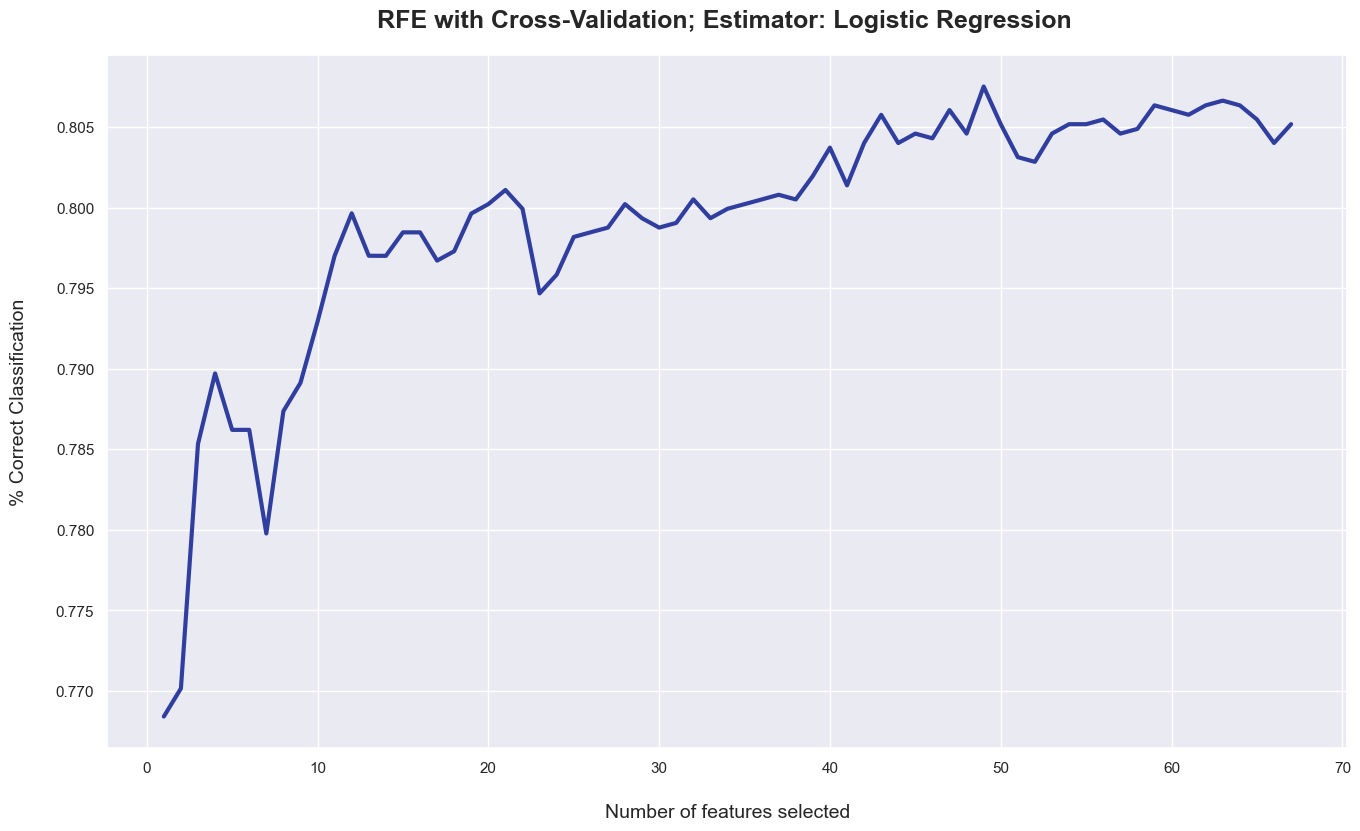

In [90]:
plt.figure(figsize=(16, 9))
plt.title('RFE with Cross-Validation; Estimator: Logistic Regression ', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Number of features selected', 
           fontsize=14, 
           labelpad=20)
plt.ylabel('% Correct Classification', 
           fontsize=14, 
           labelpad=20)
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score']) + 1), 
         rfecv_lr.cv_results_['mean_test_score'], 
         color='#303F9F', 
         linewidth=3)

plt.show()

In [91]:
rfecv_lr.estimator_.coef_[0]

array([ 0.32332627,  0.24374722,  0.34999589, -0.31234741, -0.57754486,
       -0.20365683, -0.34349511,  0.2593006 , -0.32315929,  0.35021374,
        0.245307  ,  0.42099063,  0.56179808,  0.41313671,  0.62315041,
        0.72382446,  0.40464121,  0.14858524,  0.91358071,  0.31848955,
        0.26205657,  0.73760809, -0.31735316,  0.20362228,  0.36908599,
       -0.28991167,  0.59895795,  0.33062531,  0.24015172,  0.27845322,
        0.45522522,  0.17151432,  0.96556761, -0.72451825,  0.48549757,
       -0.34384908,  0.91091209,  0.29251649,  0.38883529,  0.30967995,
        0.20252747,  0.24644427, -0.72905739, -0.39116149, -0.45848644,
       -0.56206442, -0.7337994 , -0.32593626,  3.11425801])

In [92]:
X_lr = X.drop(X.columns[np.where(rfecv_lr.support_ == False)[0]], axis=1)

Text(0.5, 1.0, 'Feature Importance; Estimator: Logistic Regression')

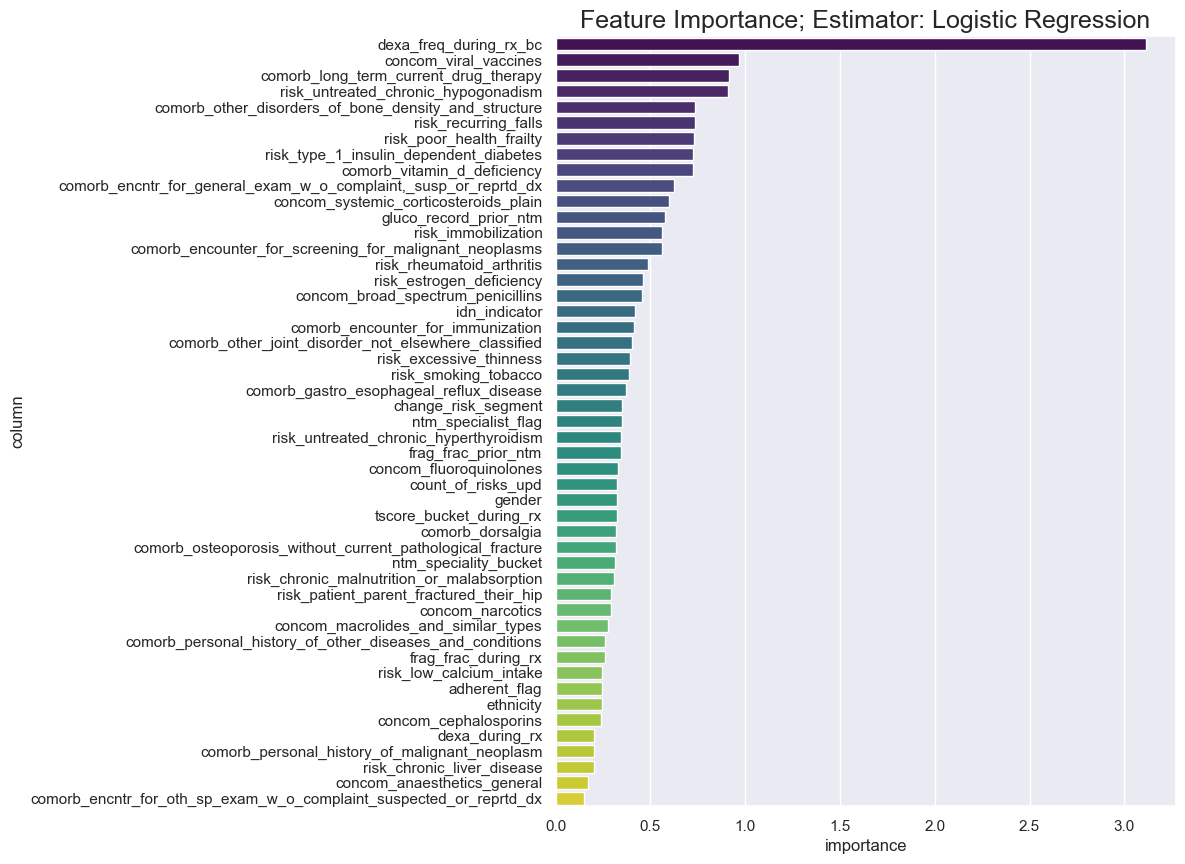

In [93]:
lr_est_df = pd.DataFrame()

lr_est_df['column'] = X_lr.columns
lr_est_df['importance'] = np.abs(rfecv_lr.estimator_.coef_[0])

lr_est_df.sort_values(by='importance', 
                      ascending=False, 
                      inplace=True, 
                      ignore_index=True)

sns.set(rc = {'figure.figsize':(8,10)})
ax = sns.barplot(y='column', 
                 x='importance',
                 data=lr_est_df,
                 palette='viridis')
ax.set_title('Feature Importance; Estimator: Logistic Regression', 
             fontsize=18)

In the above plot, when we observe the descrease in the importance score, a steady decrease can be seen after a score of **0.5** which is *concom_systemic_corticosteroids_plain* feature. Hence, we will select all the features above this.

In [94]:
X_lr = X_lr[['comorb_long_term_current_drug_therapy', 'comorb_encounter_for_screening_for_malignant_neoplasms',
             'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx', 'risk_recurring_falls', 'risk_immobilization',
             'gluco_record_prior_ntm', 'risk_poor_health_frailty', 'risk_type_1_insulin_dependent_diabetes', 
             'concom_viral_vaccines', 'comorb_vitamin_d_deficiency', 'comorb_other_disorders_of_bone_density_and_structure', 
             'dexa_freq_during_rx_bc', 'risk_untreated_chronic_hypogonadism', 'concom_systemic_corticosteroids_plain']]

In [95]:
X_lr['persistency_flag'] = target.tolist()

rfecv_lr_fp = curr_dir + '/Dataset/RFECV_LR_Healthcare_dataset.xlsx'
X_lr.to_excel(rfecv_lr_fp, index=False)

In [147]:
rfecv_lr_fp = curr_dir + '/Dataset/RFECV_LR_Healthcare_dataset.xlsx'
X_lr = pd.read_excel(rfecv_lr_fp)

# 🏤Model Building/Selection

## Features selected using RFECV: Logistic Regression 

#### Split the Dataset into train, validation and test data

In [148]:
X_lr.drop('persistency_flag', axis=1, inplace=True)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_lr, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    shuffle=True)

In [150]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

## Logistic Regression

Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
F1 score: 0.73
Accuracy: 0.7993527508090615
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       184
           1       0.81      0.66      0.73       125

    accuracy                           0.80       309
   macro avg       0.80      0.78      0.78       309
weighted avg       0.80      0.80      0.80       309



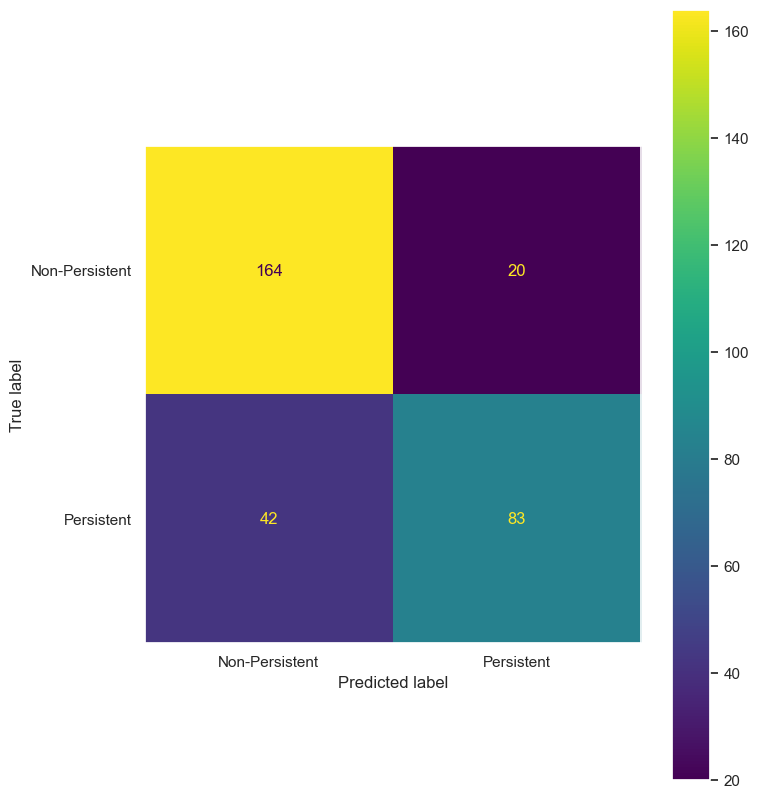

In [153]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

model = LogisticRegression()

# Perform GridSearchCV with F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Logistic Regression model with the best hyperparameters
lr_model = LogisticRegression(**best_params)
lr_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = lr_model.predict(X_val)

# Evaluate accuracy
f1_score_ = f1_score(y_val, y_pred)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])
cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
metric = {}
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
f1 = np.round(f1,2)
metric['Logistic Regression'] = {'F1_NP': f1[0],
                                 'F1_P': f1[1],
                                 'Accuracy': np.round(accuracy,2)}

pred_prob_lr = lr_model.predict_proba(X_val)

## Support Vector Classifier

Best Hyperparameters: {'C': 0.1, 'kernel': 'rbf'}
F1 score: 0.70
Accuracy: 0.7864077669902912
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83       184
           1       0.82      0.61      0.70       125

    accuracy                           0.79       309
   macro avg       0.80      0.76      0.77       309
weighted avg       0.79      0.79      0.78       309



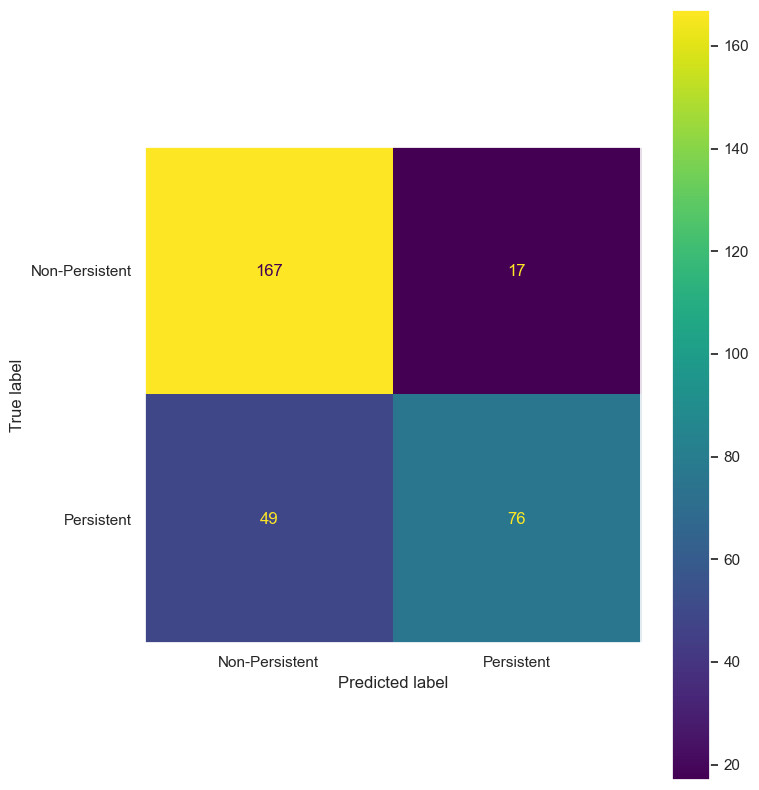

In [155]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

model = SVC(probability=True)

# Perform GridSearchCV with F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a SVC model with the best hyperparameters
svc_model = SVC(**best_params, probability=True)
svc_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = svc_model.predict(X_val)

# Evaluate accuracy
f1_score_ = f1_score(y_val, y_pred)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])

cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
f1 = np.round(f1,2)
metric['SVM'] = {'F1_NP': f1[0],
                 'F1_P': f1[1],
                 'Accuracy': np.round(accuracy,2)}

pred_prob_SVC = svc_model.predict_proba(X_val)

## Random Forest Classifier

Best Hyperparameters: {'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 50}
F1 score: 0.73
Accuracy: 0.8025889967637541
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.84       184
           1       0.81      0.66      0.73       125

    accuracy                           0.80       309
   macro avg       0.81      0.78      0.79       309
weighted avg       0.80      0.80      0.80       309



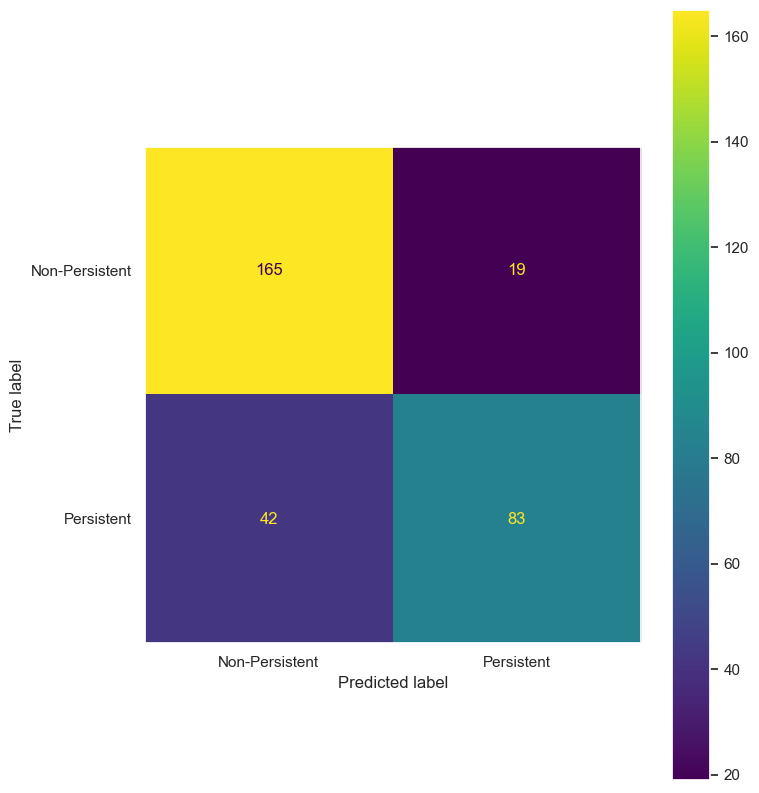

In [156]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [None, 20, 50],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()

# Perform GridSearchCV with F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Random Forest model with the best hyperparameters
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = rf_model.predict(X_val)

# Evaluate accuracy
f1_score_ = f1_score(y_val, y_pred)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])

cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
f1 = np.round(f1,2)
metric['Random Forest'] = {'F1_NP': f1[0],
                           'F1_P': f1[1],
                           'Accuracy': np.round(accuracy,2)}

pred_prob_rfc = rf_model.predict_proba(X_val)

## Cat Boost

Best Hyperparameters: {'depth': 2, 'iterations': 200, 'l2_leaf_reg': 6, 'learning_rate': 0.1}
F1 score: 0.71
Accuracy: 0.7961165048543689
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       184
           1       0.82      0.63      0.71       125

    accuracy                           0.80       309
   macro avg       0.80      0.77      0.78       309
weighted avg       0.80      0.80      0.79       309



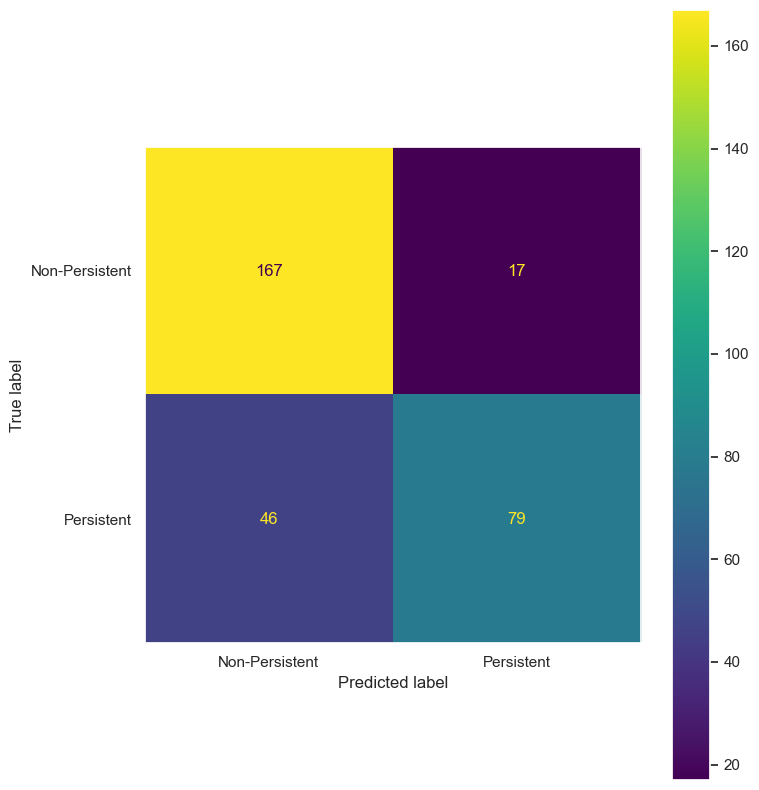

In [157]:
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'depth': [2, 3],
    'l2_leaf_reg': [4, 6, 8]
}
model = CatBoostClassifier(verbose=False)

# Perform GridSearchCV with F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Catboost model with the best hyperparameters
cb_model = CatBoostClassifier(**best_params, verbose=False)
cb_model.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred = cb_model.predict(X_val)

# Evaluate accuracy
f1_score_ = f1_score(y_val, y_pred)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])

cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
f1 = np.round(f1,2)
metric['Cat Boost'] = {'F1_NP': f1[0],
                       'F1_P': f1[1],
                       'Accuracy': np.round(accuracy,2)}

pred_prob_cb = cb_model.predict_proba(X_val)

### ROC_AUC 

#### AUC scores 

In [161]:
auc_score_lr = np.round(roc_auc_score(y_val, pred_prob_lr[:,1]), 2)
auc_score_svc = np.round(roc_auc_score(y_val, pred_prob_SVC[:,1]), 2)
auc_score_rfc = np.round(roc_auc_score(y_val, pred_prob_rfc[:,1]), 2)
auc_score_cb = np.round(roc_auc_score(y_val, pred_prob_cb[:,1]), 2)

auc_scores = np.array([auc_score_lr, auc_score_svc, auc_score_rfc, auc_score_cb])
auc_scores_df = pd.DataFrame({'Model' : ['Logistic Regression', 
                                         'Support Vector Classifier', 
                                         'Random Forest Classifier', 
                                         'Catboost']})
auc_scores_df['AUC scores'] = auc_scores
auc_scores_df

,Model,AUC scores
0,Logistic Regression,0.87
1,Support Vector Classifier,0.85
2,Random Forest Classifier,0.85
3,Catboost,0.87


#### ROC curve 

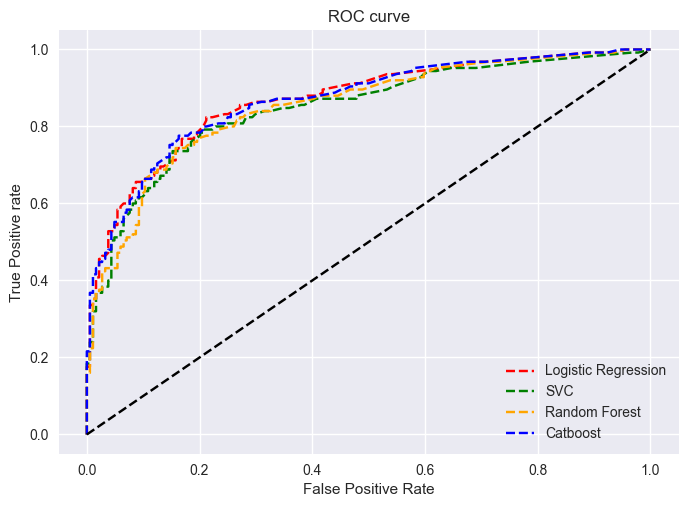

In [165]:
# roc curve for models
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_val, pred_prob_lr[:,1], pos_label=1)
fpr_svc, tpr_svc, thresh_svc = roc_curve(y_val, pred_prob_SVC[:,1], pos_label=1)
fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_val, pred_prob_rfc[:,1], pos_label=1)
fpr_cb, tpr_cb, thresh_cb = roc_curve(y_val, pred_prob_cb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)


plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='red', label='Logistic Regression')
plt.plot(fpr_svc, tpr_svc, linestyle='--',color='green', label='SVC')
plt.plot(fpr_rfc, tpr_rfc, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr_cb, tpr_cb, linestyle='--',color='blue', label='Catboost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

## Testing

## Logistic Regression

F1 score: 0.73
Accuracy: 0.8046647230320699
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       213
           1       0.77      0.69      0.73       130

    accuracy                           0.80       343
   macro avg       0.80      0.78      0.79       343
weighted avg       0.80      0.80      0.80       343



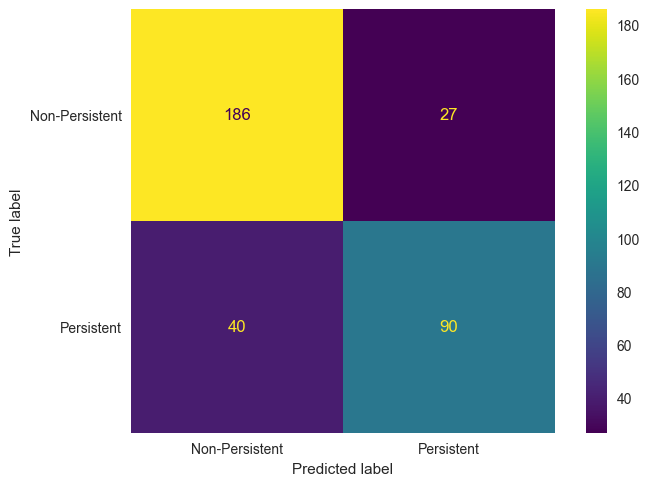

In [167]:
# Predict on the test set using the best model
y_pred_test = lr_model.predict(X_test)

# Evaluate accuracy
f1_score_ = f1_score(y_test, y_pred_test)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])
cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
metric_test = {}
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
f1 = np.round(f1,2)
metric_test['Logistic Regression'] = {'F1_NP': f1[0],
                                    'F1_P': f1[1],
                                    'Accuracy': np.round(accuracy,2)}

pred_prob_lr = lr_model.predict_proba(X_test)

## Support Vector Classifier

F1 score: 0.69
Accuracy: 0.7813411078717201
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       213
           1       0.75      0.64      0.69       130

    accuracy                           0.78       343
   macro avg       0.77      0.75      0.76       343
weighted avg       0.78      0.78      0.78       343



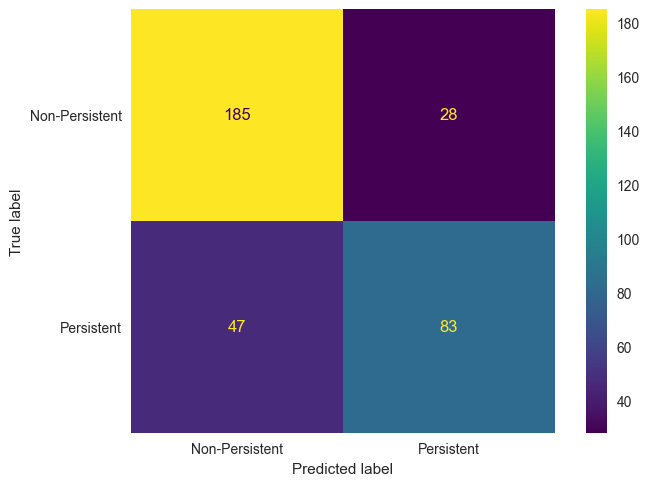

In [168]:
# Predict on the test set using the best model
y_pred_test = svc_model.predict(X_test)

# Evaluate accuracy
f1_score_ = f1_score(y_test, y_pred_test)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])
cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
metric = {}
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
f1 = np.round(f1,2)
metric_test['SVM'] = {'F1_NP': f1[0],
                      'F1_P': f1[1],
                      'Accuracy': np.round(accuracy,2)}

pred_prob_SVC = svc_model.predict_proba(X_test)

## Random Forest Classifier

F1 score: 0.69
Accuracy: 0.7784256559766763
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       213
           1       0.73      0.65      0.69       130

    accuracy                           0.78       343
   macro avg       0.77      0.75      0.76       343
weighted avg       0.78      0.78      0.78       343



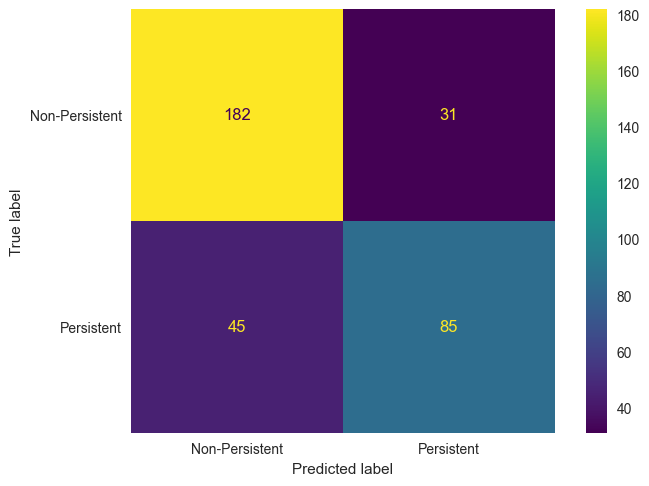

In [169]:
# Predict on the test set using the best model
y_pred_test = rf_model.predict(X_test)

# Evaluate accuracy
f1_score_ = f1_score(y_test, y_pred_test)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])
cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
metric = {}
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
f1 = np.round(f1,2)
metric_test['Random Forest'] = {'F1_NP': f1[0],
                                'F1_P': f1[1],
                                'Accuracy': np.round(accuracy,2)}

pred_prob_rfc = rf_model.predict_proba(X_test)

## Cat Boost

F1 score: 0.71
Accuracy: 0.793002915451895
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       213
           1       0.76      0.66      0.71       130

    accuracy                           0.79       343
   macro avg       0.78      0.77      0.77       343
weighted avg       0.79      0.79      0.79       343



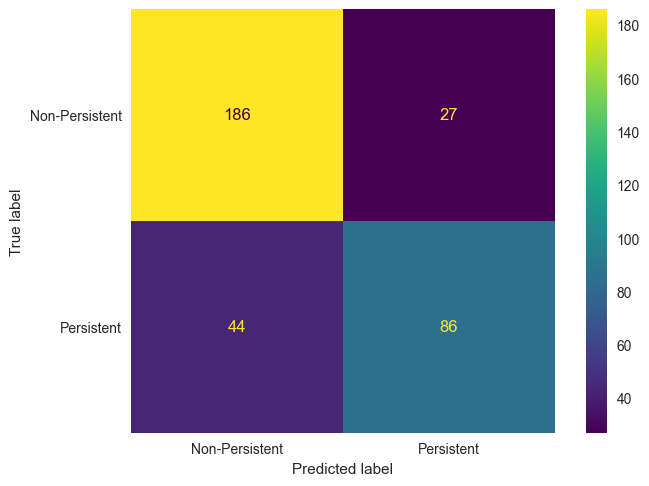

In [170]:
# Predict on the test set using the best model
y_pred_test = cb_model.predict(X_test)

# Evaluate accuracy
f1_score_ = f1_score(y_test, y_pred_test)
print(f"F1 score: {f1_score_:.2f}")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:",accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Persistent", "Persistent"])
cm_display.plot()
plt.grid(False)
plt.show()

# Creating a dictionary that stores f1 score and accuracy for each model
metric = {}
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
f1 = np.round(f1,2)
metric_test['Catboost'] = {'F1_NP': f1[0],
                           'F1_P': f1[1],
                           'Accuracy': np.round(accuracy,2)}

pred_prob_cb = cb_model.predict_proba(X_test)

### ROC_AUC 

#### AUC scores 

In [173]:
auc_score_lr = np.round(roc_auc_score(y_test, pred_prob_lr[:,1]), 2)
auc_score_svc = np.round(roc_auc_score(y_test, pred_prob_SVC[:,1]), 2)
auc_score_rfc = np.round(roc_auc_score(y_test, pred_prob_rfc[:,1]), 2)
auc_score_cb = np.round(roc_auc_score(y_test, pred_prob_cb[:,1]), 2)

auc_scores = np.array([auc_score_lr, auc_score_svc, auc_score_rfc, auc_score_cb])
auc_scores_df = pd.DataFrame({'Model' : ['Logistic Regression', 
                                         'Support Vector Classifier', 
                                         'Random Forest Classifier', 
                                         'Catboost']})
auc_scores_df['AUC scores'] = auc_scores
auc_scores_df

,Model,AUC scores
0,Logistic Regression,0.85
1,Support Vector Classifier,0.84
2,Random Forest Classifier,0.82
3,Catboost,0.85


#### ROC curve 

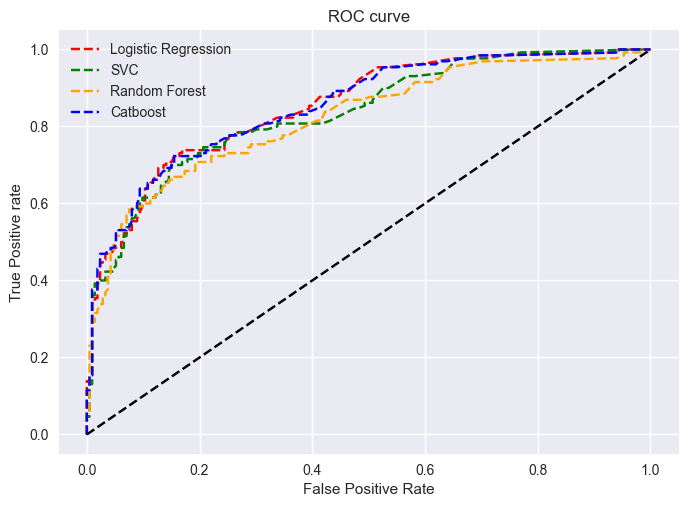

In [174]:
# roc curve for models
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test, pred_prob_lr[:,1], pos_label=1)
fpr_svc, tpr_svc, thresh_svc = roc_curve(y_test, pred_prob_SVC[:,1], pos_label=1)
fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_test, pred_prob_rfc[:,1], pos_label=1)
fpr_cb, tpr_cb, thresh_cb = roc_curve(y_test, pred_prob_cb[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='red', label='Logistic Regression')
plt.plot(fpr_svc, tpr_svc, linestyle='--',color='green', label='SVC')
plt.plot(fpr_rfc, tpr_rfc, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr_cb, tpr_cb, linestyle='--',color='blue', label='Catboost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### Model Evaluation 

> ***Val data perrformance***

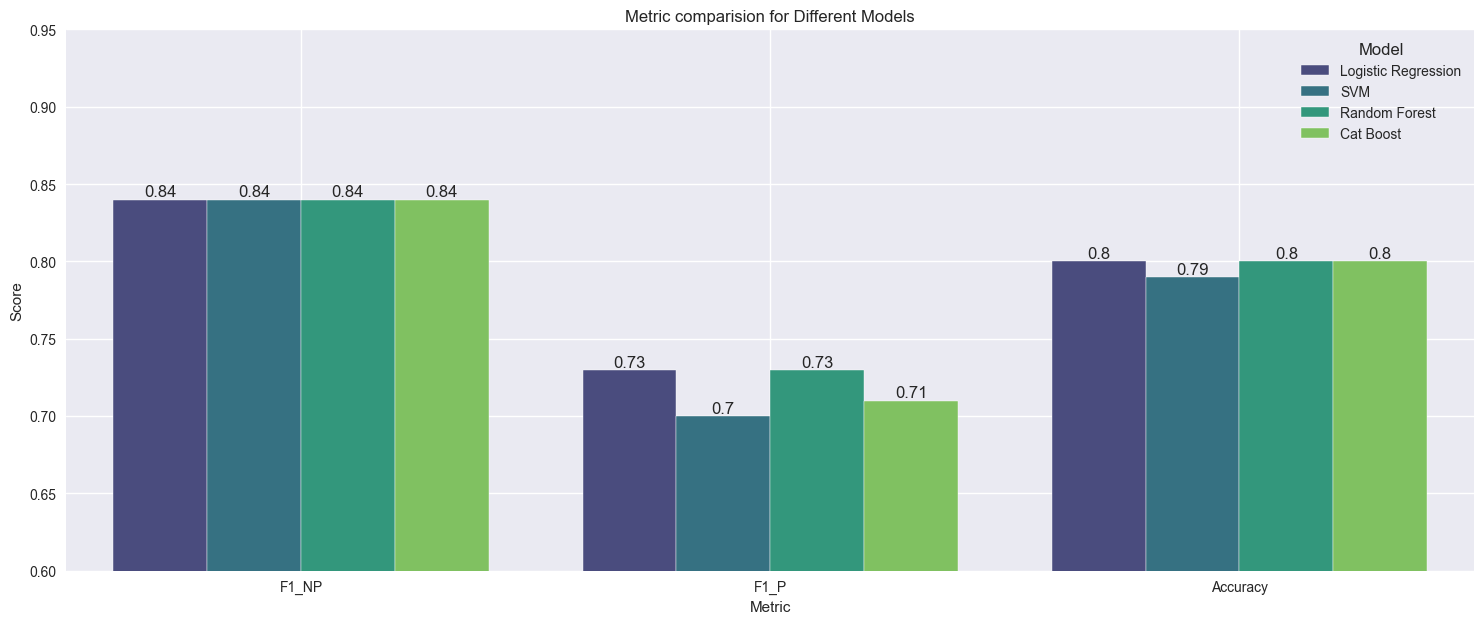

In [166]:
df_final = pd.DataFrame(metric).rename_axis(index='Metric').reset_index().melt(id_vars='Metric', 
                                                                               var_name='Model', 
                                                                               value_name='Percentage')

# Plotting
plt.figure(figsize=(15, 12))

# Bar plot for F1 scores
plt.subplot(2, 1, 1)
f1_plot = sns.barplot(data=df_final, y='Percentage', x='Metric', hue='Model', palette='viridis')
plt.title('Metric comparision for Different Models')
plt.ylabel('Score')
plt.ylim(0.6, 0.95)  # Set y-axis range
plt.grid(axis='x')

for label in f1_plot.containers:
    f1_plot.bar_label(label)

plt.tight_layout()
plt.show()

> ***Test data performance***

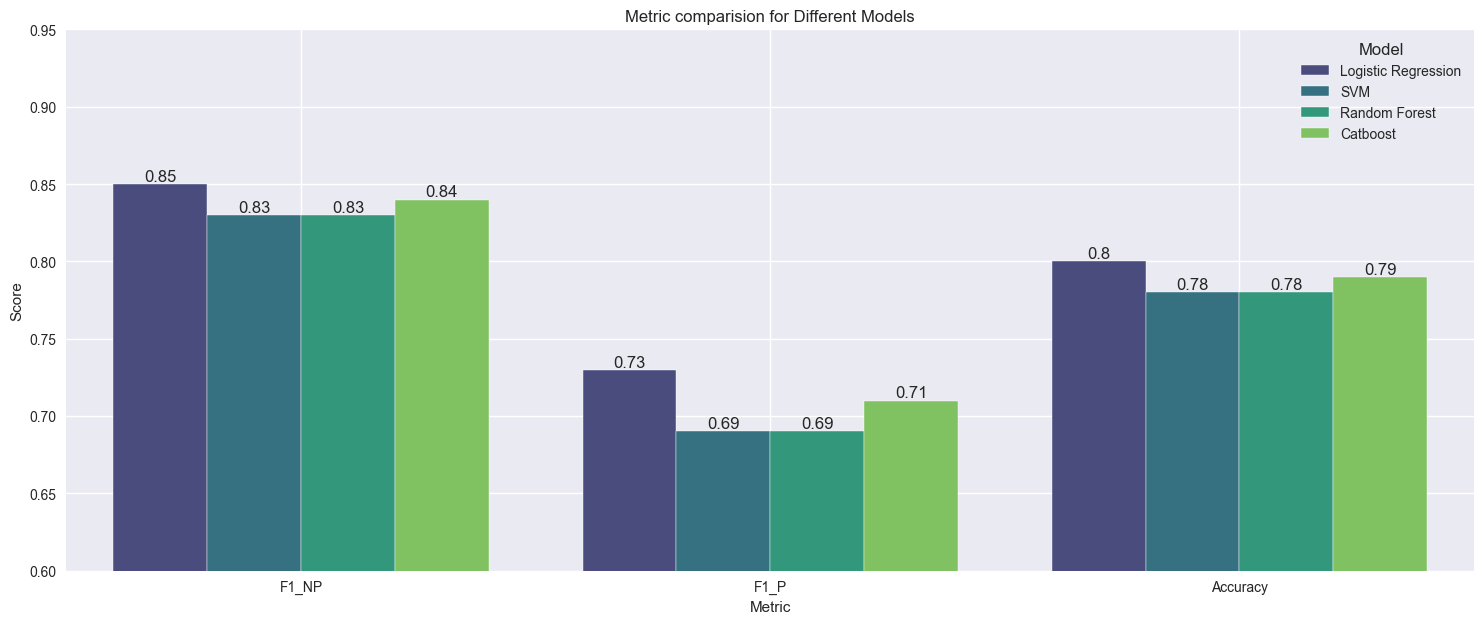

In [171]:
df_final = pd.DataFrame(metric_test).rename_axis(index='Metric').reset_index().melt(id_vars='Metric', 
                                                                                    var_name='Model', 
                                                                                    value_name='Percentage')

# Plotting
plt.figure(figsize=(15, 12))

# Bar plot for F1 scores
plt.subplot(2, 1, 1)
f1_plot = sns.barplot(data=df_final, y='Percentage', x='Metric', hue='Model', palette='viridis')
plt.title('Metric comparision for Different Models')
plt.ylabel('Score')
plt.ylim(0.6, 0.95)  # Set y-axis range
plt.grid(axis='x')

for label in f1_plot.containers:
    f1_plot.bar_label(label)

plt.tight_layout()
plt.show()

**As evident from above two graphs, Logistic Regression has almost similar F1 scores and Accuracies for both validation and test data. The only challenge we see is that the models other than Logistic Regression are overfitting on the validation data and performing poorly on test data, which suggests that this model is generalizing well to unseen data and the performance is also better than the other models. Hence, we are selecting Logistic Regression as our final model.**

> ***Saving the model***

In [145]:
with open('LR_model.pkl', 'wb') as file:
    pkl.dump(lr_model, file)

print('Saved logistic regression model to disk')

Saved logistic regression model to disk
